## WANDB Scrape and Results

### Imports

In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
from env.imports import *

In [54]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run
from sim.wandb_scrape import *

#### Check job specs

In [55]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 4.8%
RAM Usage: 4.7%
Available RAM: 1.4T
Total RAM: 1.5T
52.4G


## Wandb API Query <a id="sims"></a>

Search and plot Random

In [9]:
from collections import defaultdict

# Define model groups and their valid feature types
models = ['cge', 'gaussian_kernel', 'exponential_decay',
          'bilinear_CM', 'pls_bilineardecoder', 'bilinear_lowrank',
          'dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']

# Dictionary mapping models to their required feature types
model_feature_types = {
    'cge': ['transcriptome_PCA'],
    'gaussian_kernel': ['euclidean'],
    'exponential_decay': ['euclidean'],
    'bilinear_CM': ['transcriptome', 'transcriptome_PCA'],
    'pls_bilineardecoder': ['transcriptome'],
    'bilinear_lowrank': ['transcriptome'],
    'dynamic_mlp': ['transcriptome', 'transcriptome+euclidean'],
    'shared_transformer': ['transcriptome'],
    'shared_transformer_cls': ['transcriptome']
}

# Time ranges for true models
time_ranges_true = {
    'default': {'within_last': 120, 'before_last': 0},
    'model_specific': {
        'cge': {'within_last': 120, 'before_last': 0},
        'gaussian_kernel': {'within_last': 120, 'before_last': 0},
        'exponential_decay': {'within_last': 120, 'before_last': 0},
        'bilinear_CM': {'within_last': 120, 'before_last': 0},
        'pls_bilineardecoder': {'within_last': 120, 'before_last': 0},
        'bilinear_lowrank': {'within_last': 120, 'before_last': 20},
        'dynamic_mlp': {'within_last': 30, 'before_last': 20},
        'shared_transformer': {'within_last': 30, 'before_last': 20},
        'shared_transformer_cls': {'within_last': 30, 'before_last': 20},
        # 'dynamic_mlp': {'within_last': 7, 'before_last': 2},
        # 'shared_transformer': {'within_last': 7, 'before_last': 2},
        # 'shared_transformer_cls': {'within_last': 7, 'before_last': 2},
    }
}

# Time ranges for null models
time_ranges_spin = {
    'default': {'within_last': 120, 'before_last': 0},
    'model_specific': {
        'cge': {'within_last': 120, 'before_last': 0},
        'gaussian_kernel': {'within_last': 120, 'before_last': 0},
        'exponential_decay': {'within_last': 120, 'before_last': 0},
        'bilinear_CM': {'within_last': 120, 'before_last': 0},
        'pls_bilineardecoder': {'within_last': 120, 'before_last': 0},
        'bilinear_lowrank': {'within_last': 120, 'before_last': 0},
        'dynamic_mlp': {'within_last': 120, 'before_last': 0},
        'shared_transformer': {'within_last': 21, 'before_last': 0},
        'shared_transformer_cls': {'within_last': 21, 'before_last': 0},
        # 'dynamic_mlp': {'within_last': 120, 'before_last': 0},
        # 'shared_transformer': {'within_last': 6, 'before_last': 0},
        # 'shared_transformer_cls': {'within_last': 6, 'before_last': 0},
    }
}

cv_type = 'random'
null_model = 'none'

# Store summary DataFrames
summary_dict_random = {}
process_model_feature_combinations(cv_type, null_model, models, model_feature_types, summary_dict_random, time_ranges=time_ranges_true)

cv_type = 'random'
null_model = 'spin'

# Store summary DataFrames
summary_dict_random_spin = {}
process_model_feature_combinations(cv_type, null_model, models, model_feature_types, summary_dict_random_spin, time_ranges=time_ranges_spin)

Checking which model/feature type combinations return 40 runs for null_model=none:

🔍 Fetching runs for: model=cge, cv_type=random, null_model=none, feature_type=transcriptome_PCA


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


✓ cge with transcriptome_PCA: Successfully found 40 runs
🔍 Fetching runs for: model=gaussian_kernel, cv_type=random, null_model=none, feature_type=euclidean


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


✓ gaussian_kernel with euclidean: Successfully found 40 runs
🔍 Fetching runs for: model=exponential_decay, cv_type=random, null_model=none, feature_type=euclidean
✓ exponential_decay with euclidean: Successfully found 40 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=random, null_model=none, feature_type=transcriptome
✓ bilinear_CM: Successfully found 40 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=random, null_model=none, feature_type=transcriptome_PCA
✓ bilinear_CM_PCA: Successfully found 40 runs
🔍 Fetching runs for: model=pls_bilineardecoder, cv_type=random, null_model=none, feature_type=transcriptome
✓ pls_bilineardecoder with transcriptome: Successfully found 40 runs
🔍 Fetching runs for: model=bilinear_lowrank, cv_type=random, null_model=none, feature_type=transcriptome
✓ bilinear_lowrank with transcriptome: Successfully found 40 runs
🔍 Fetching runs for: model=dynamic_mlp, cv_type=random, null_model=none, feature_type=transcriptome
✓ dynamic_mlp: Successfully found 

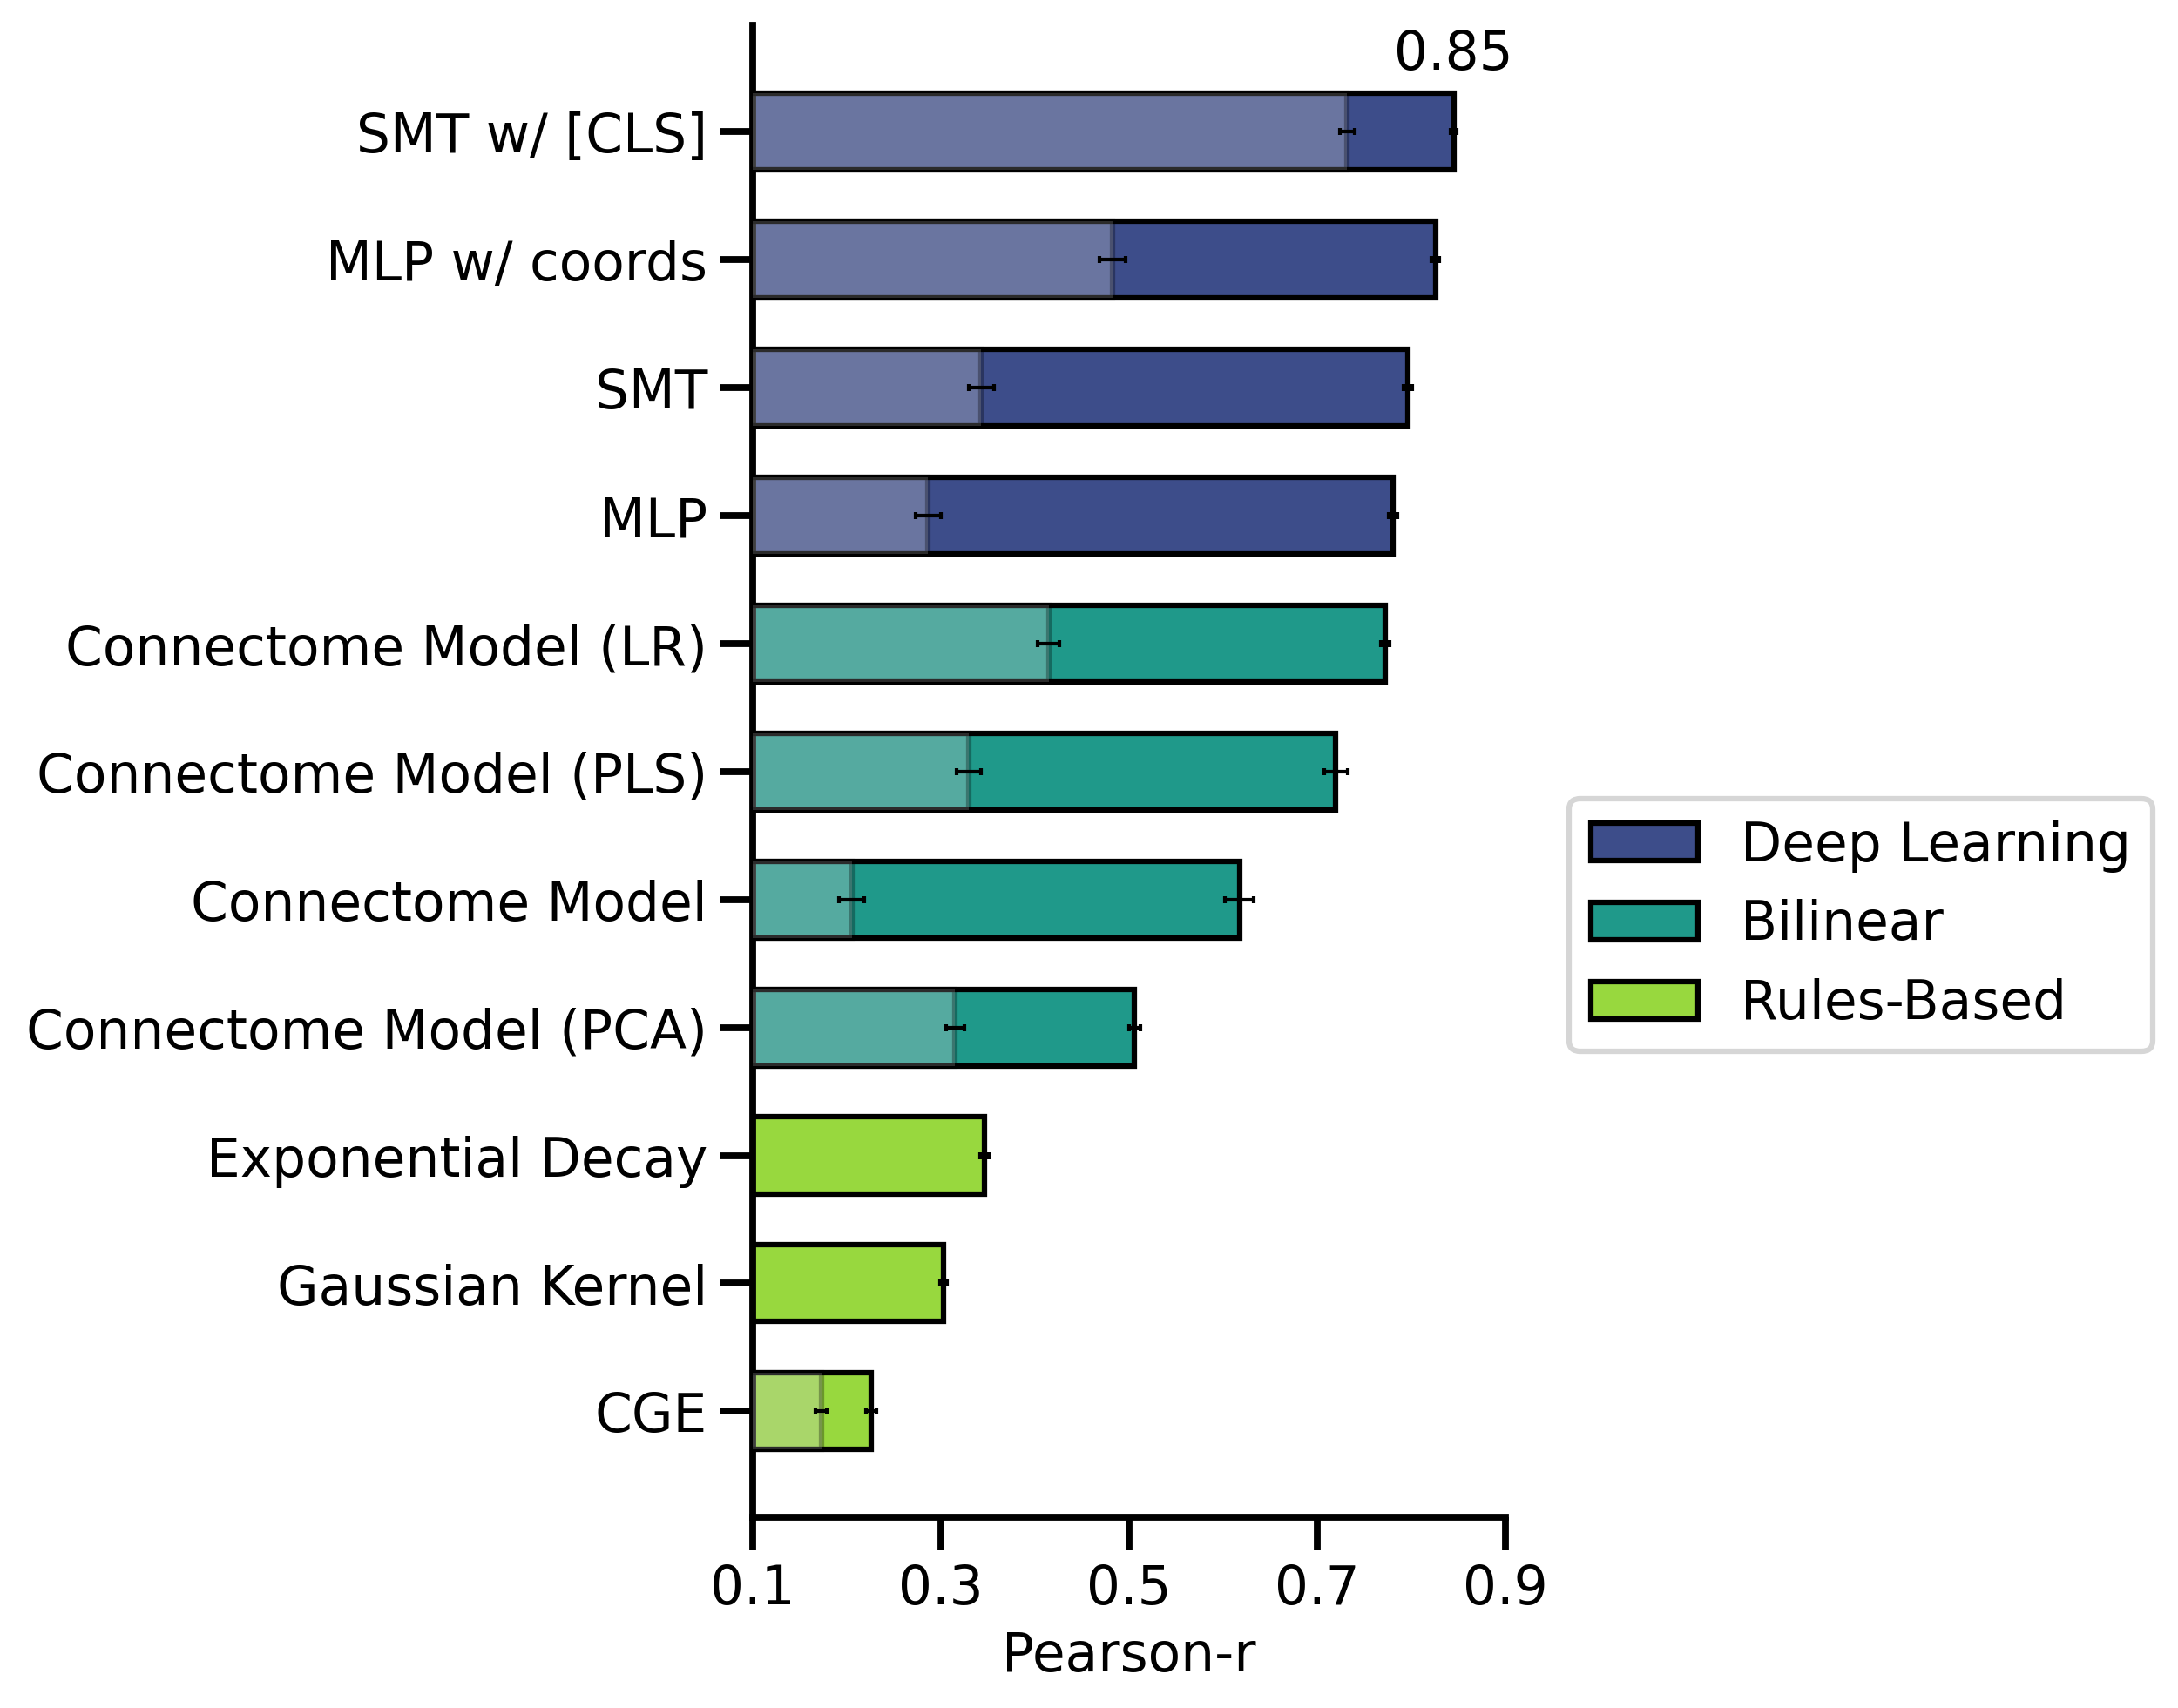

In [11]:
plot_true_vs_null_model_barchart_w_legend(
    summary_true_dict=summary_dict_random,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_random_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    xlim=(0.1, 0.9),
    overlay_style='alpha'                          # or 'alpha'

)

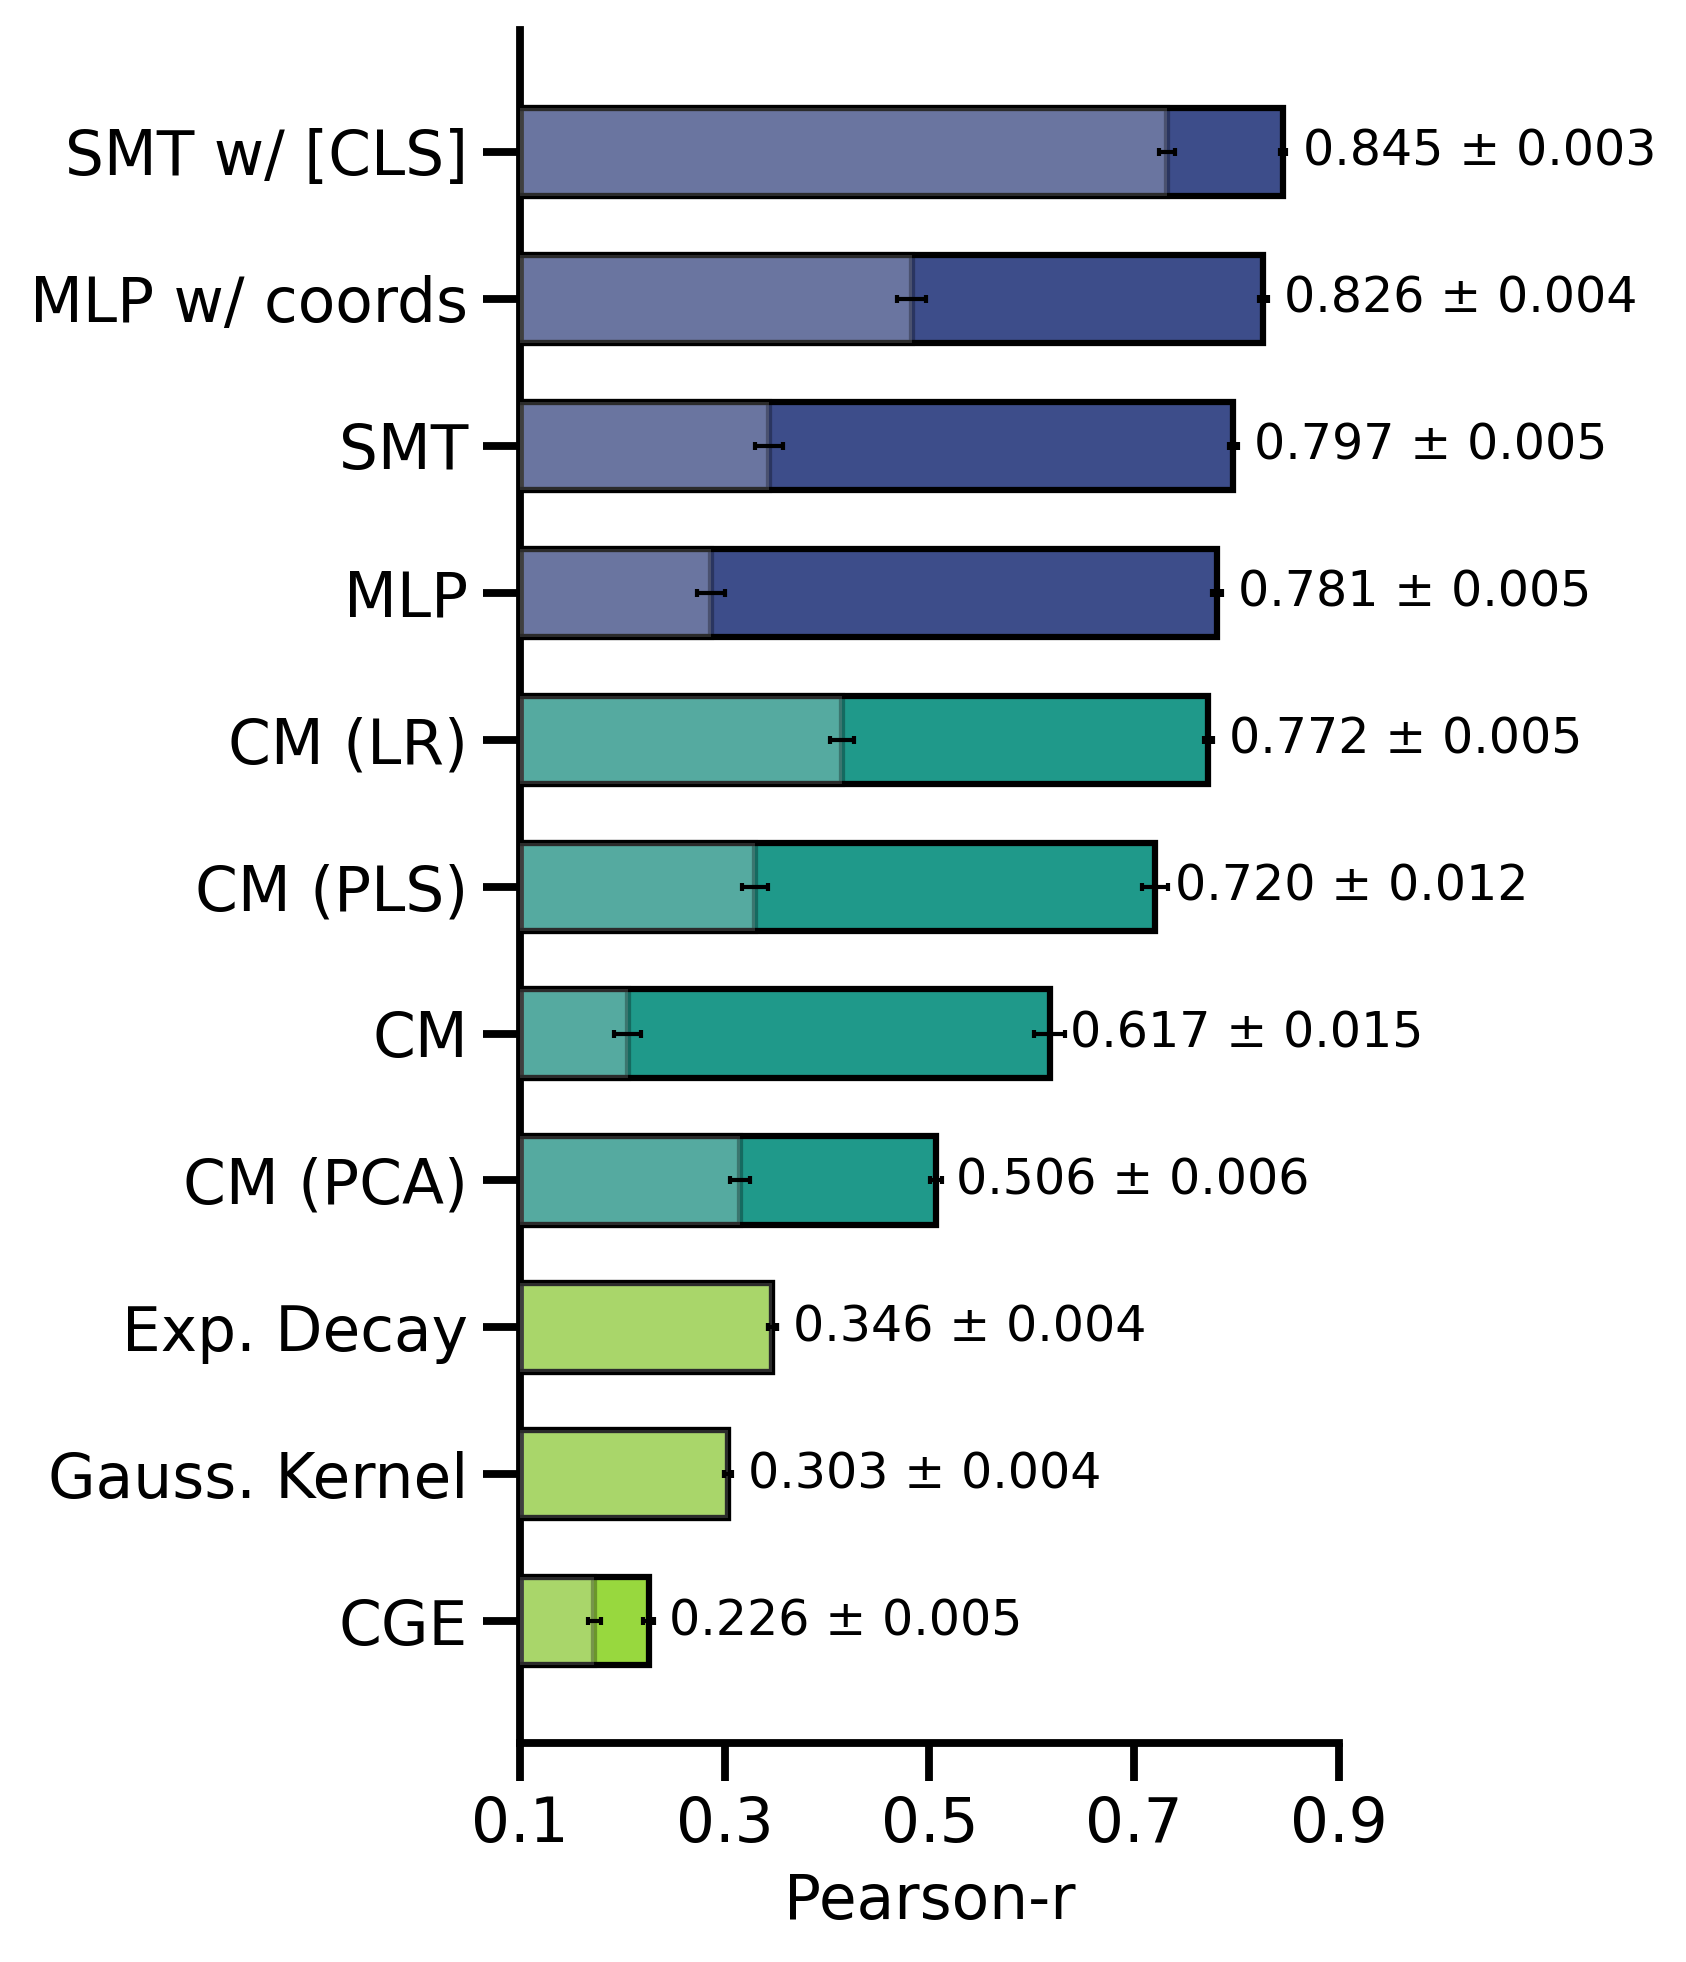

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [12]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_random,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_random_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    xlim=(0.1, 0.9),
    overlay_style='alpha',                          # or 'alpha'
    display_metric=True
)

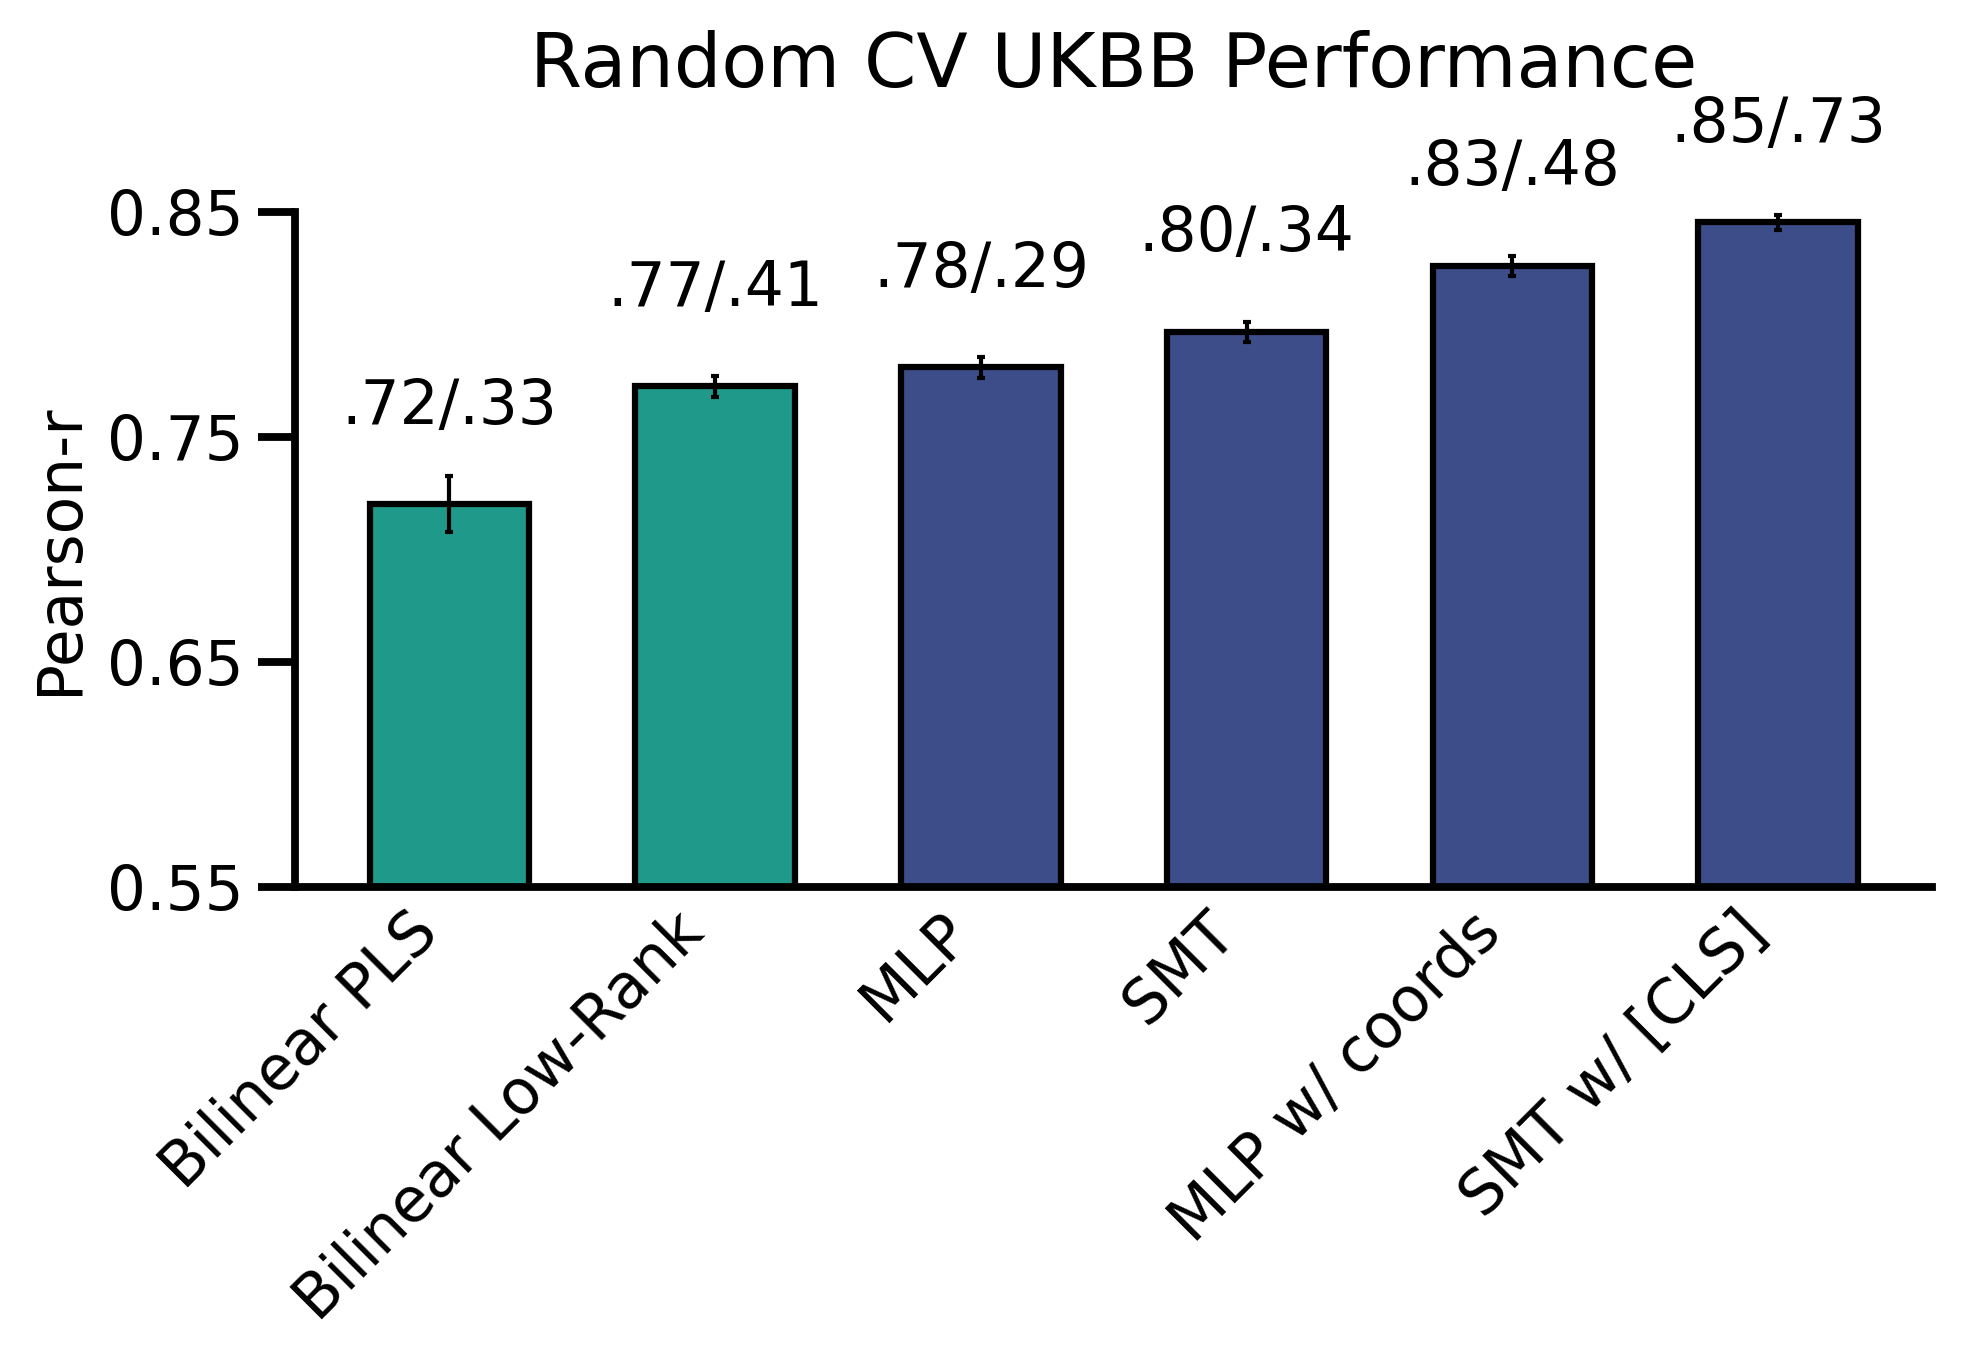

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253)}

In [76]:
plot_final_subsetted_barchart(
    summary_true_dict=summary_dict_random,        # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_random_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    ylim=(0.55, .85),
    overlay_style='ratio',                          # or 'alpha'
    #display_metric=False,
    title="Random CV UKBB Performance",
    horizontal=True
)

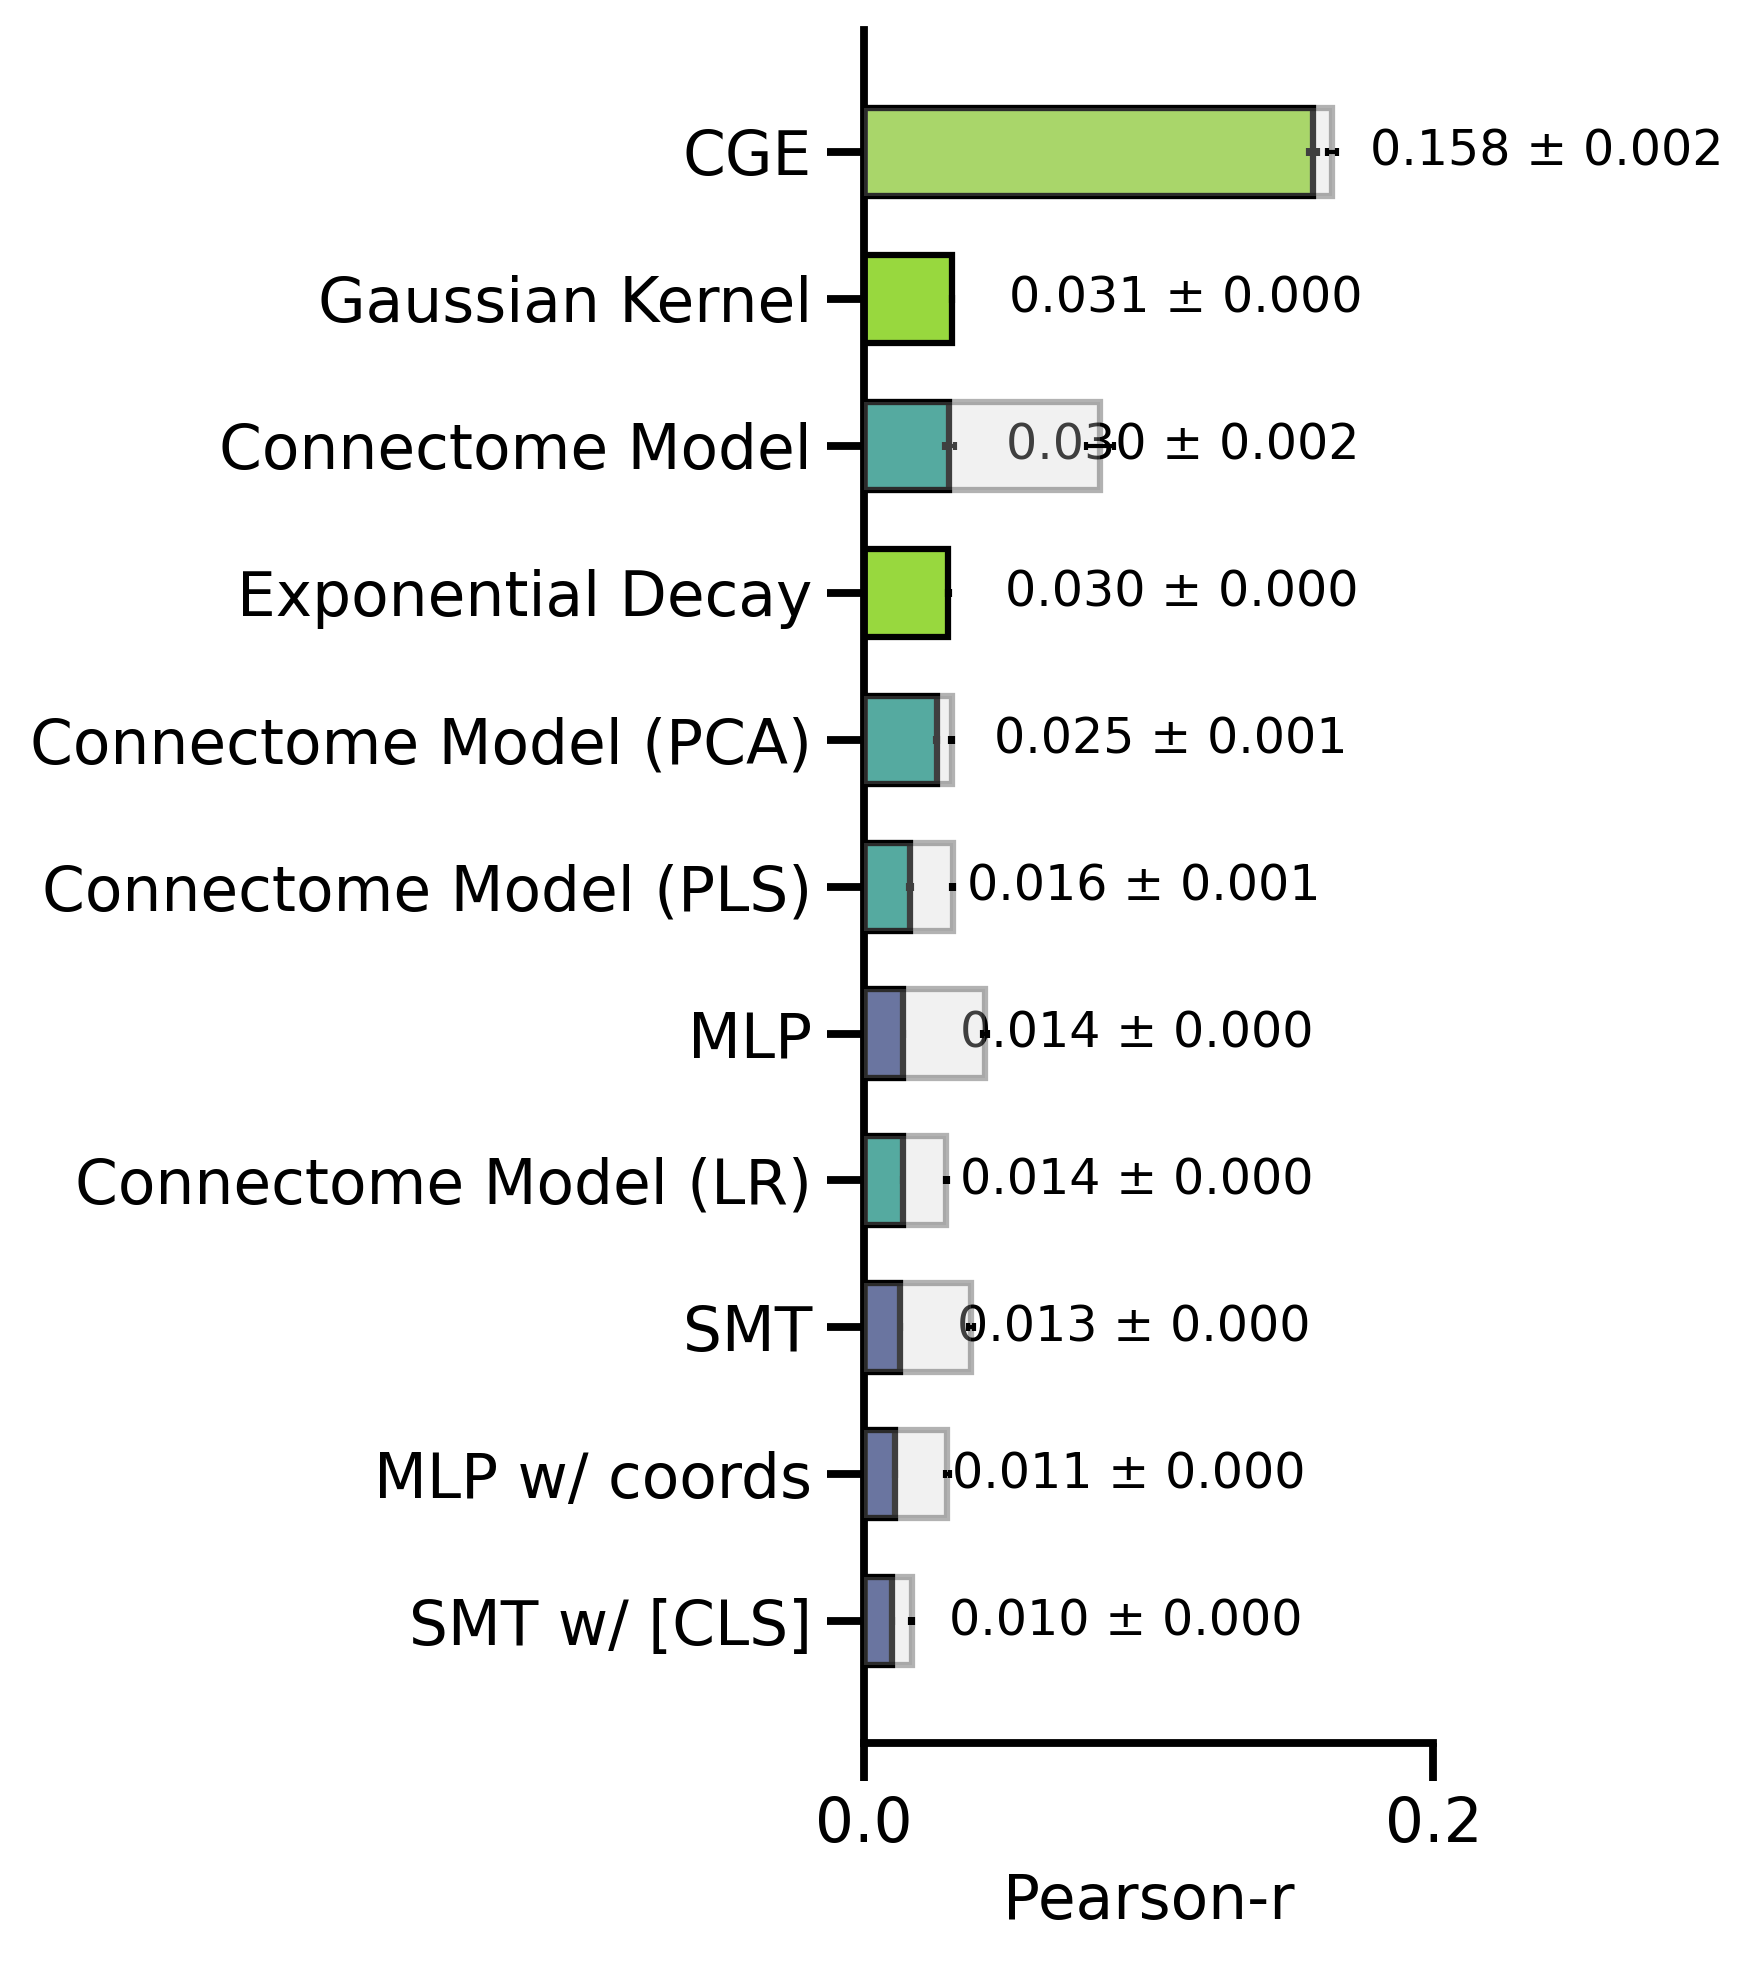

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [34]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_random,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_random_spin,           # cv_type='spatial', null_model='spin'
    metric="test_mse",
    xlim=(0.0, 0.05),
    overlay_style='alpha',                          # or 'alpha'
    display_metric=True
)

Search and plot spatial

In [20]:
# Define model groups and their valid feature types
models = ['cge', 'gaussian_kernel', 'exponential_decay',
          'bilinear_CM', 'pls_bilineardecoder', 'bilinear_lowrank',
          'dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']

# Dictionary mapping models to their required feature types
model_feature_types = {
    'cge': ['transcriptome_PCA'],
    'gaussian_kernel': ['euclidean'],
    'exponential_decay': ['euclidean'],
    'bilinear_CM': ['transcriptome', 'transcriptome_PCA'],
    'pls_bilineardecoder': ['transcriptome'],
    'bilinear_lowrank': ['transcriptome'],
    'dynamic_mlp': ['transcriptome', 'transcriptome+euclidean'],
    'shared_transformer': ['transcriptome'],
    'shared_transformer_cls': ['transcriptome']
}

model_groups = {
    'rules based': ['cge', 'gaussian_kernel', 'exponential_decay'],
    'bilinear': ['bilinear_CM', 'bilinear_CM_PCA', 'pls_bilineardecoder', 'bilinear_lowrank'],
    'deep learning': ['dynamic_mlp', 'dynamic_mlp_coords', 'shared_transformer', 'shared_transformer_cls']
}


# Time ranges for true models
time_ranges_true = {
    'default': {'within_last': 120, 'before_last': 0},
    'model_specific': {
        'cge': {'within_last': 120, 'before_last': 0},
        'gaussian_kernel': {'within_last': 120, 'before_last': 0},
        'exponential_decay': {'within_last': 120, 'before_last': 0},
        'bilinear_CM': {'within_last': 120, 'before_last': 0},
        'pls_bilineardecoder': {'within_last': 120, 'before_last': 0},
        'bilinear_lowrank': {'within_last': 120, 'before_last': 20},
        'dynamic_mlp': {'within_last': 30, 'before_last': 20},
        'shared_transformer': {'within_last': 30, 'before_last': 25},
        'shared_transformer_cls': {'within_last': 30, 'before_last': 21},
    }
}

# Time ranges for null models
time_ranges_spin = {
    'default': {'within_last': 120, 'before_last': 0},
    'model_specific': {
        'cge': {'within_last': 120, 'before_last': 0},
        'gaussian_kernel': {'within_last': 120, 'before_last': 0},
        'exponential_decay': {'within_last': 120, 'before_last': 0},
        'bilinear_CM': {'within_last': 120, 'before_last': 0},
        'pls_bilineardecoder': {'within_last': 120, 'before_last': 0},
        'bilinear_lowrank': {'within_last': 120, 'before_last': 0},
        'dynamic_mlp': {'within_last': 120, 'before_last': 0},
        'shared_transformer': {'within_last': 120, 'before_last': 0},
        'shared_transformer_cls': {'within_last': 50, 'before_last': -1},
    }
}

cv_type = 'spatial'
null_model = 'none'

# Store summary DataFrames
summary_dict_spatial = {}
process_model_feature_combinations(cv_type, null_model, models, model_feature_types, summary_dict_spatial, time_ranges=time_ranges_true)


cv_type = 'spatial'
null_model = 'spin'

# Store summary DataFrames
summary_dict_spatial_spin = {}
process_model_feature_combinations(cv_type, null_model, models, model_feature_types, summary_dict_spatial_spin, time_ranges=time_ranges_spin)

Checking which model/feature type combinations return 40 runs for null_model=none:

🔍 Fetching runs for: model=cge, cv_type=spatial, null_model=none, feature_type=transcriptome_PCA
✓ cge with transcriptome_PCA: Successfully found 40 runs
🔍 Fetching runs for: model=gaussian_kernel, cv_type=spatial, null_model=none, feature_type=euclidean
✓ gaussian_kernel with euclidean: Successfully found 40 runs
🔍 Fetching runs for: model=exponential_decay, cv_type=spatial, null_model=none, feature_type=euclidean
✓ exponential_decay with euclidean: Successfully found 40 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=spatial, null_model=none, feature_type=transcriptome
✓ bilinear_CM: Successfully found 40 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=spatial, null_model=none, feature_type=transcriptome_PCA
✓ bilinear_CM_PCA: Successfully found 40 runs
🔍 Fetching runs for: model=pls_bilineardecoder, cv_type=spatial, null_model=none, feature_type=transcriptome
✓ pls_bilineardecoder with tran

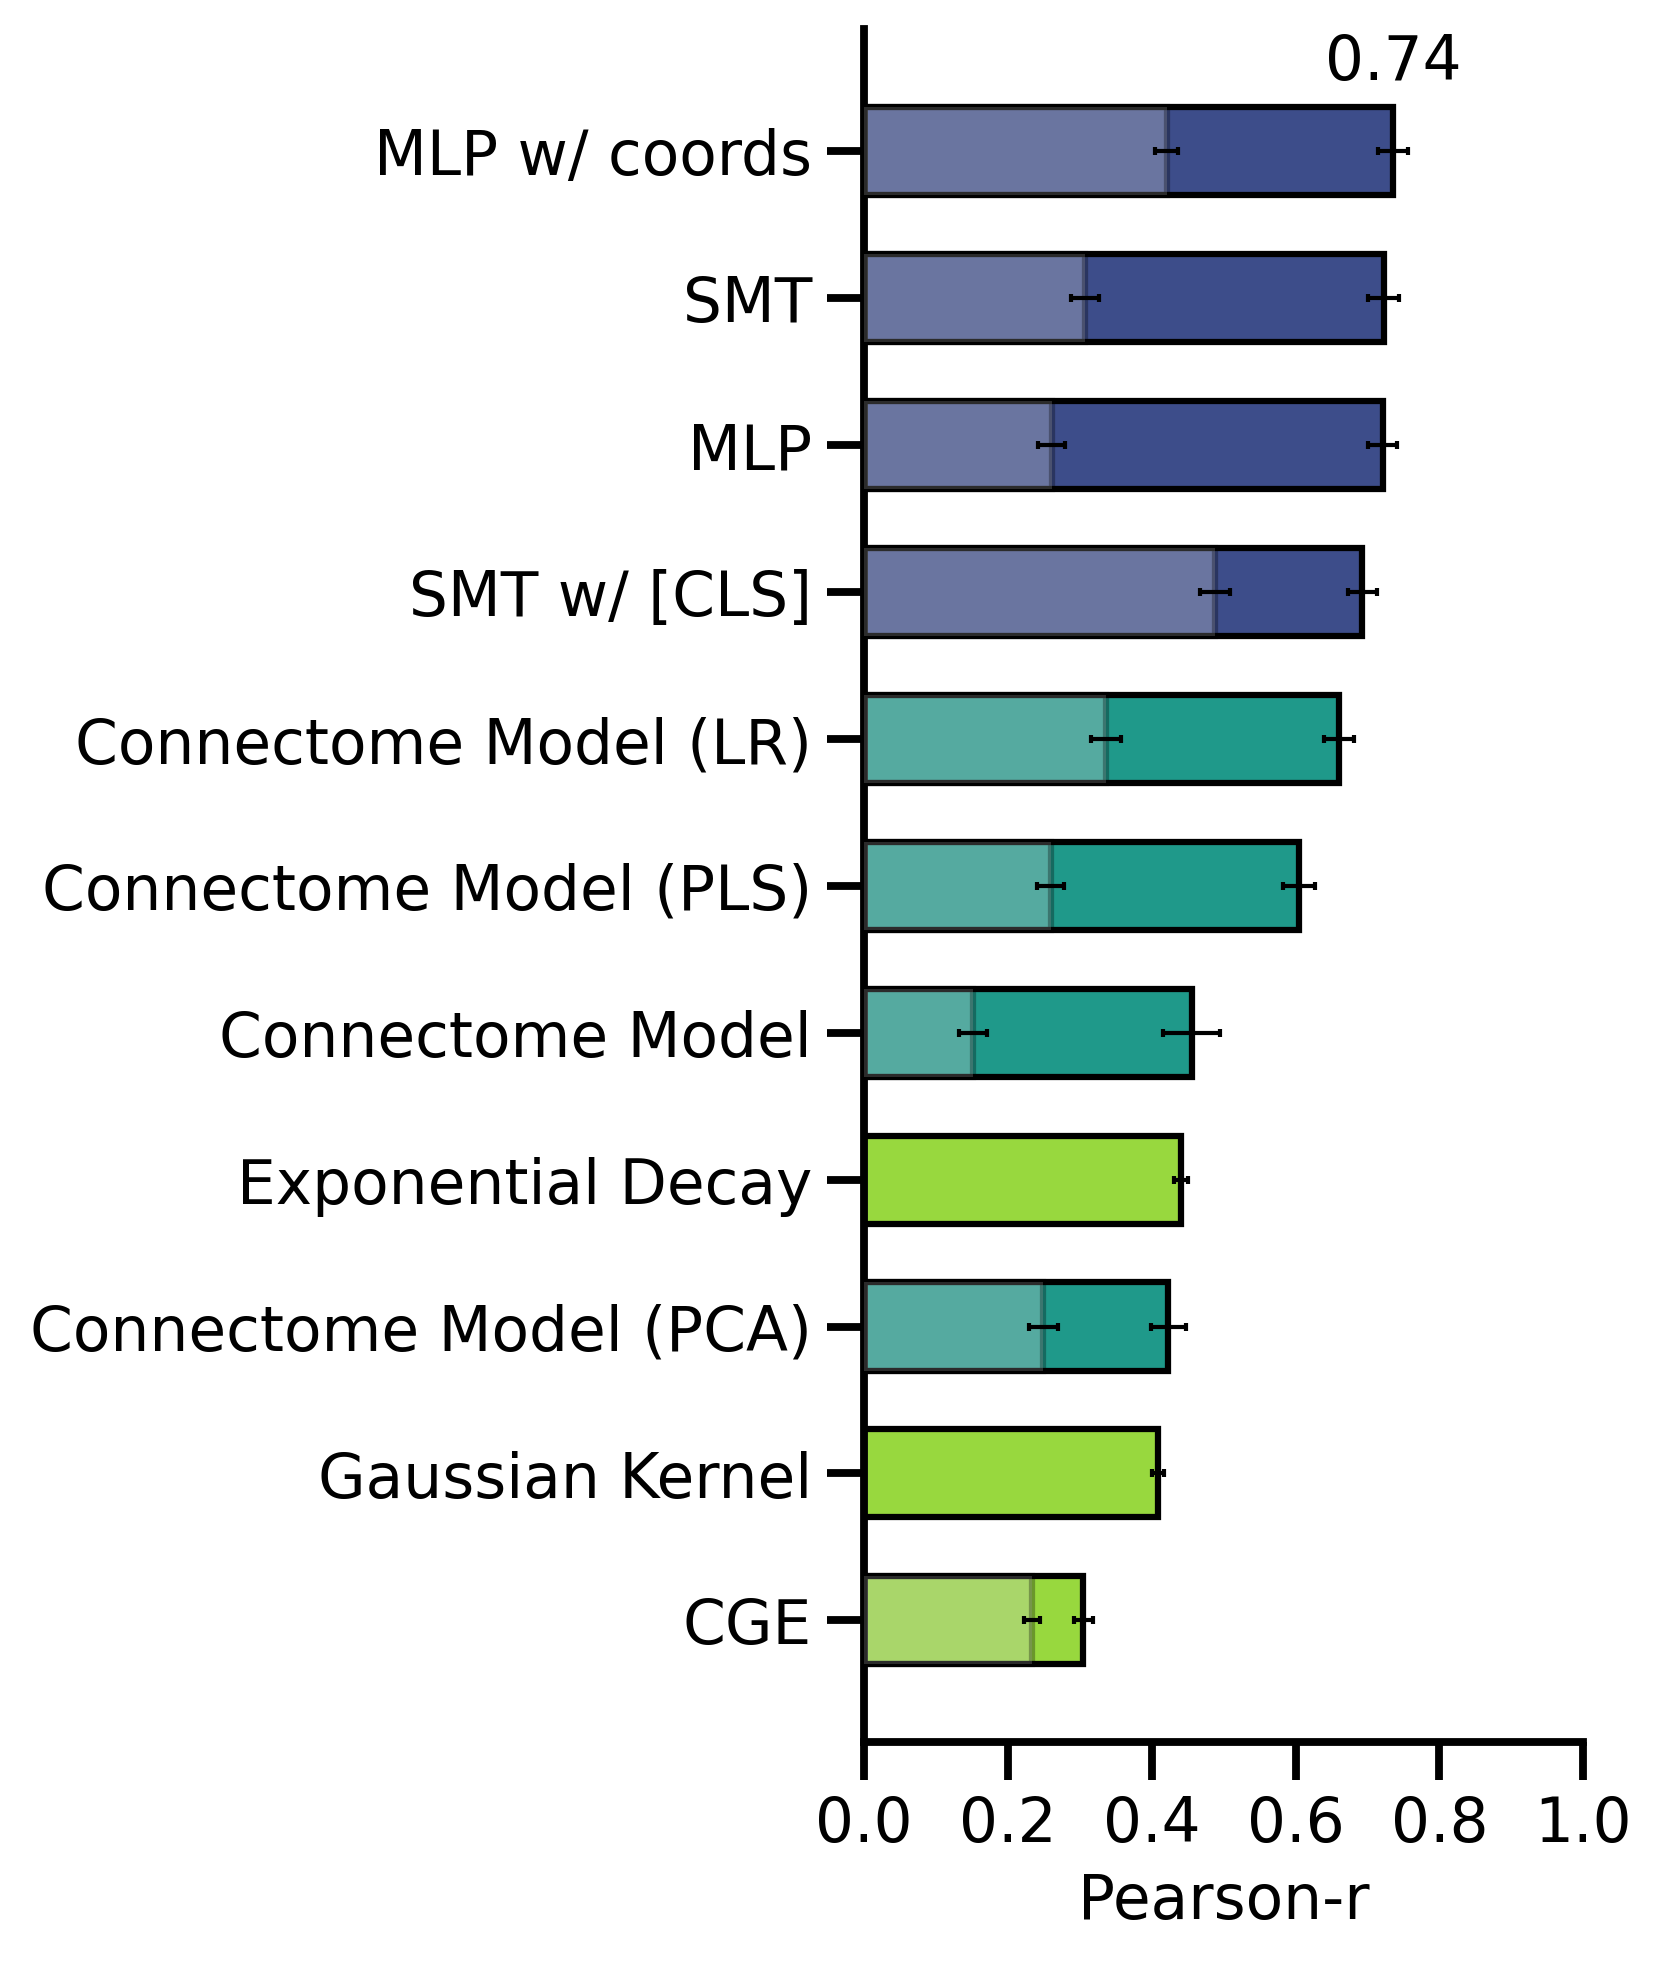

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [55]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_spatial,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_spatial_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    xlim=(0.0, 1),
    overlay_style='alpha',                          # or 'alpha'
    display_metric=False
)

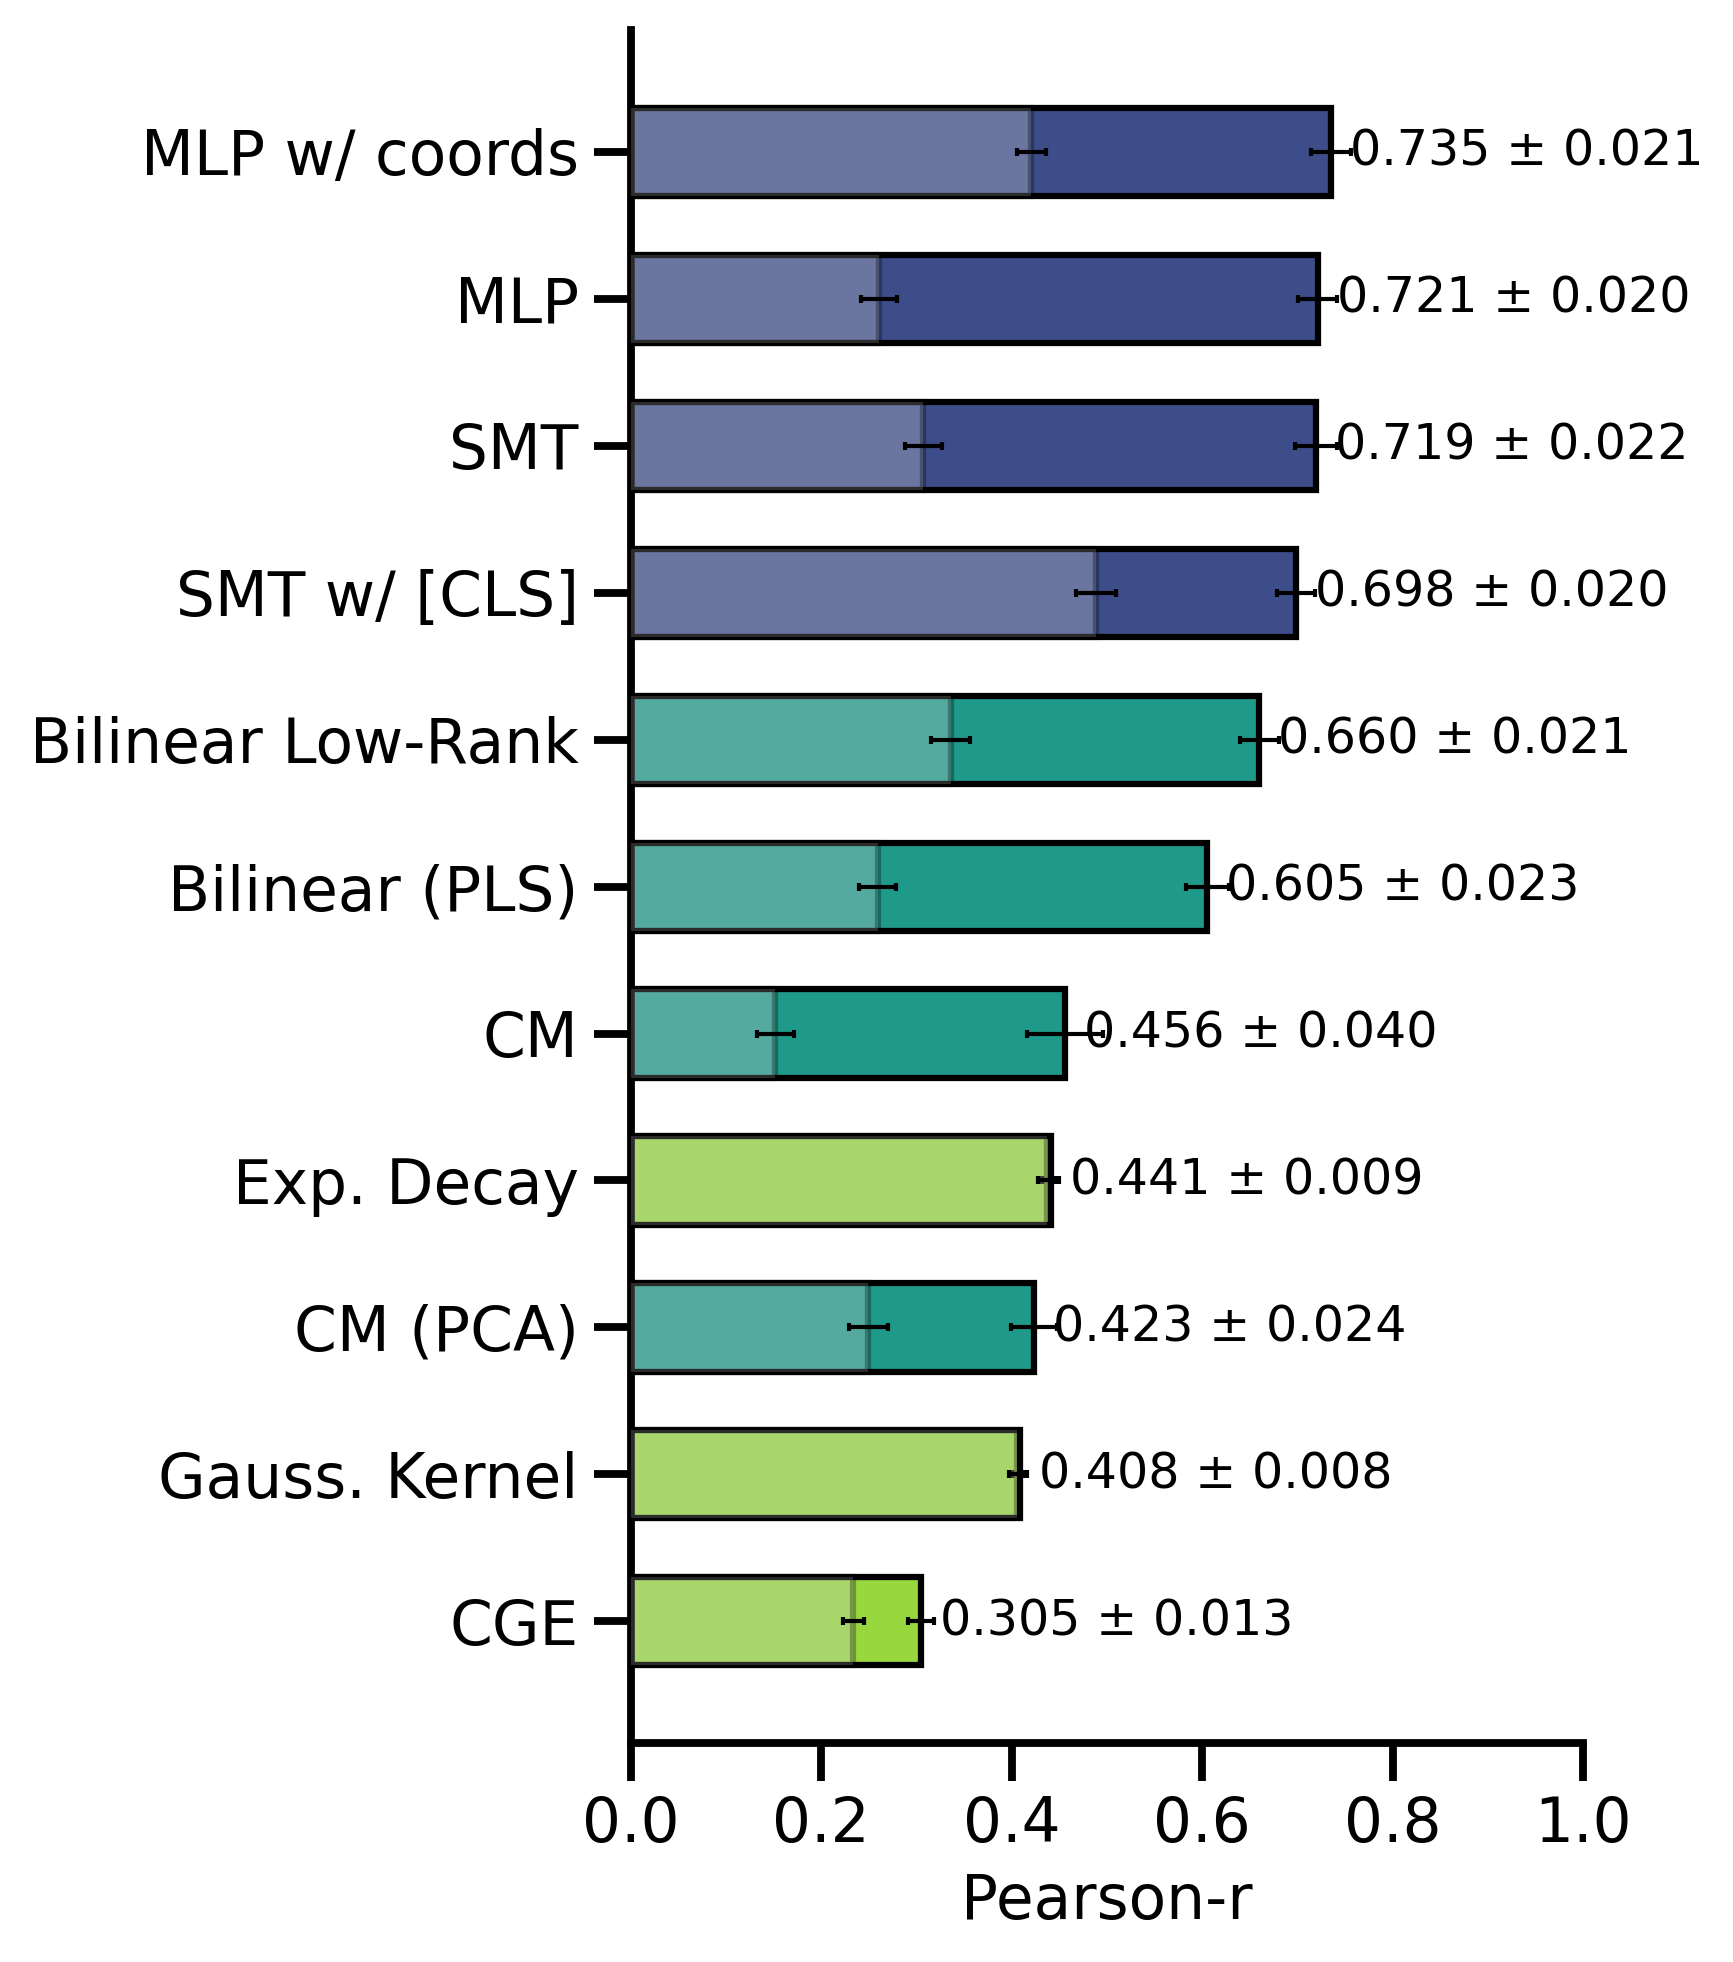

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [24]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_spatial,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_spatial_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    xlim=(0.0, 1),
    overlay_style='alpha',                          # or 'alpha'
    display_metric=True
)

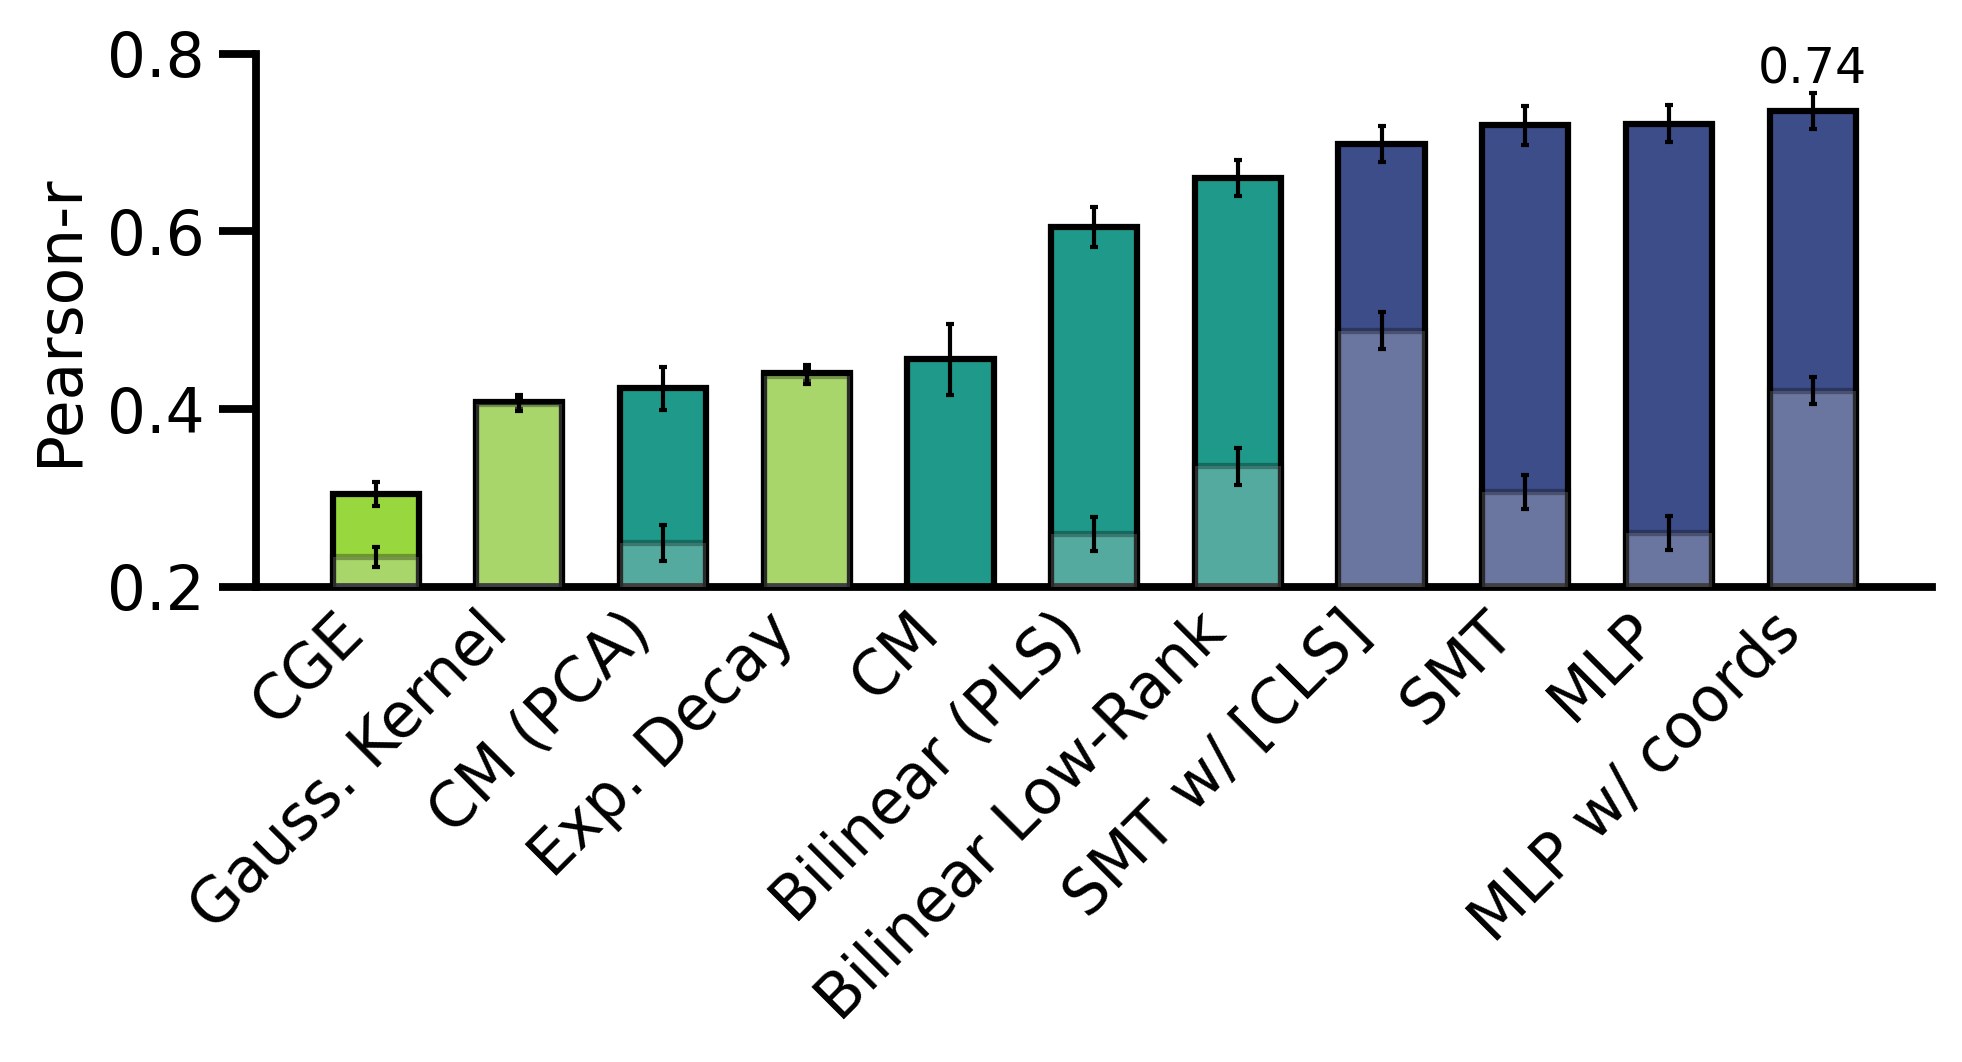

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [25]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_spatial,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_spatial_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    xlim=(0.2, .8),
    overlay_style='alpha',                          # or 'alpha'
    display_metric=False,
    horizontal=True
)

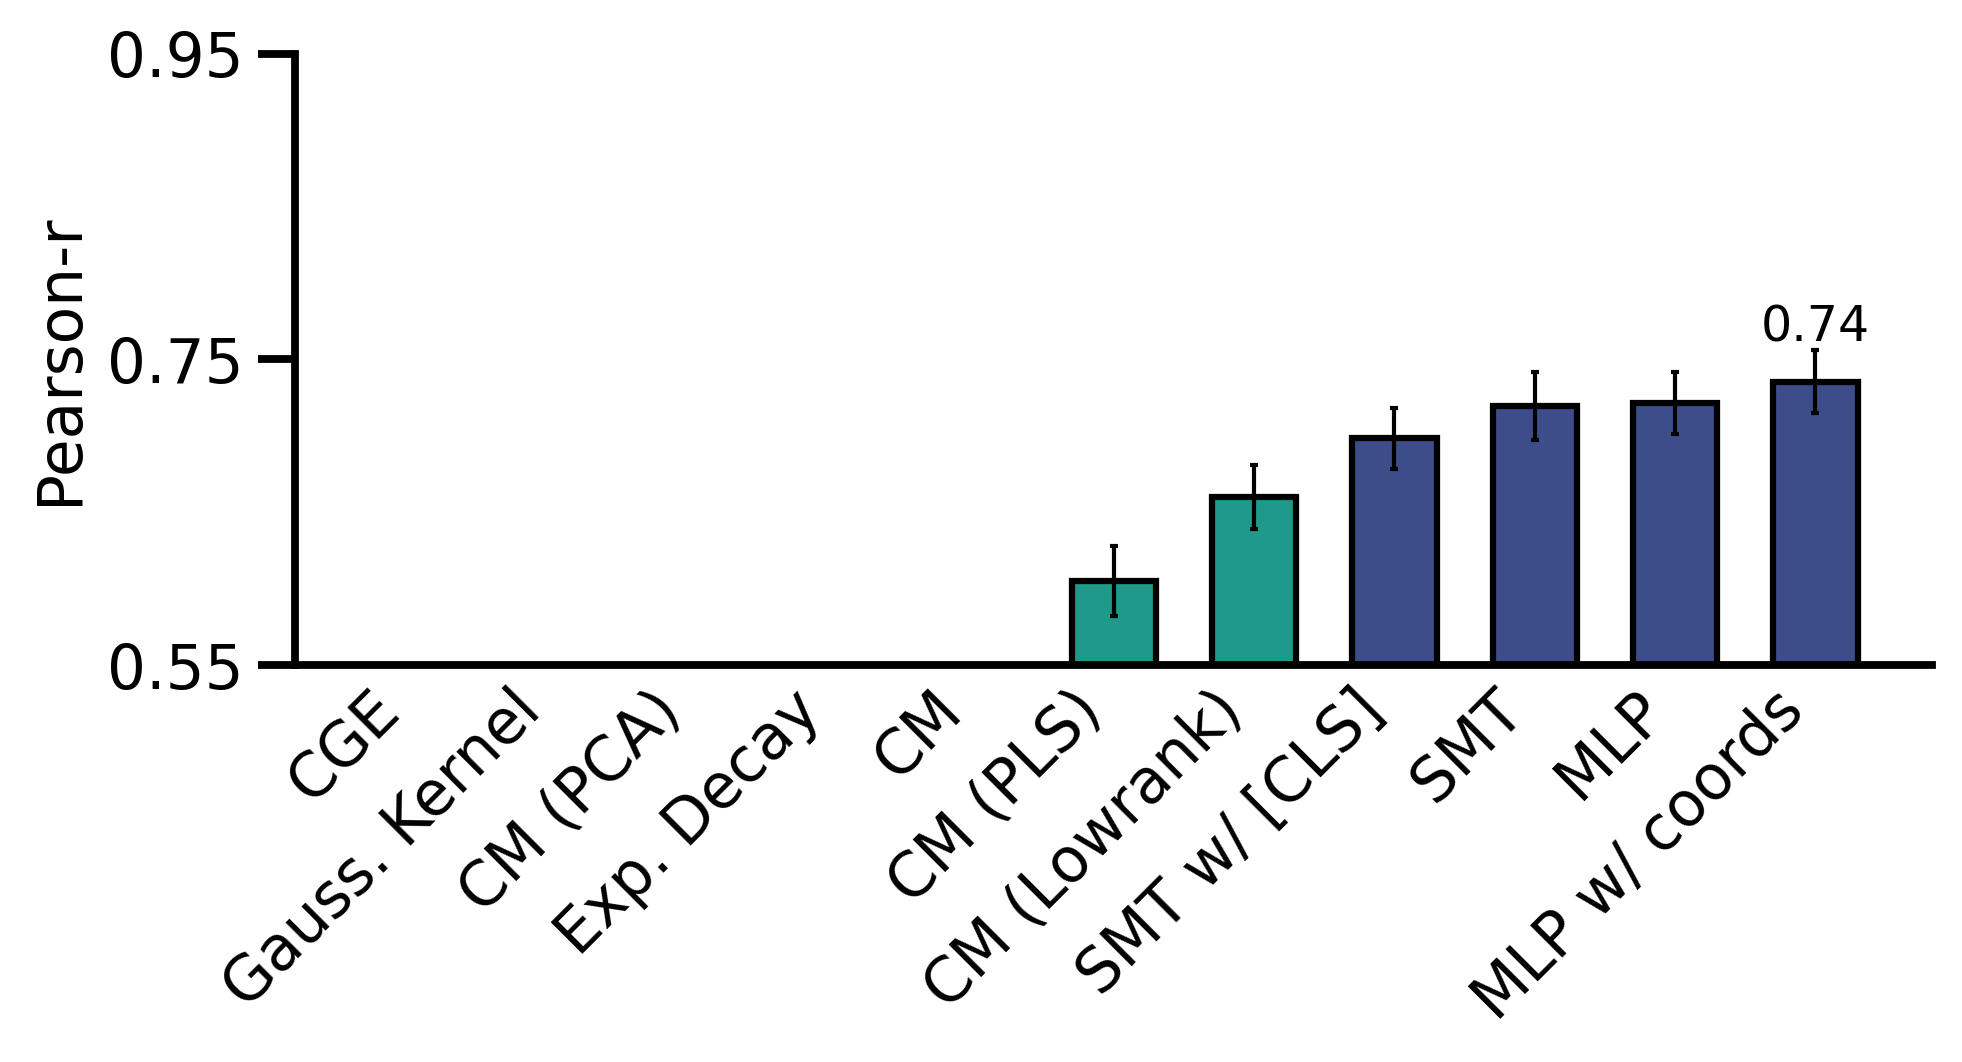

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [51]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_spatial,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_spatial_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    xlim=(0.55, .9),
    overlay_style='alpha',                          # or 'alpha'
    display_metric=False,
    horizontal=True
)

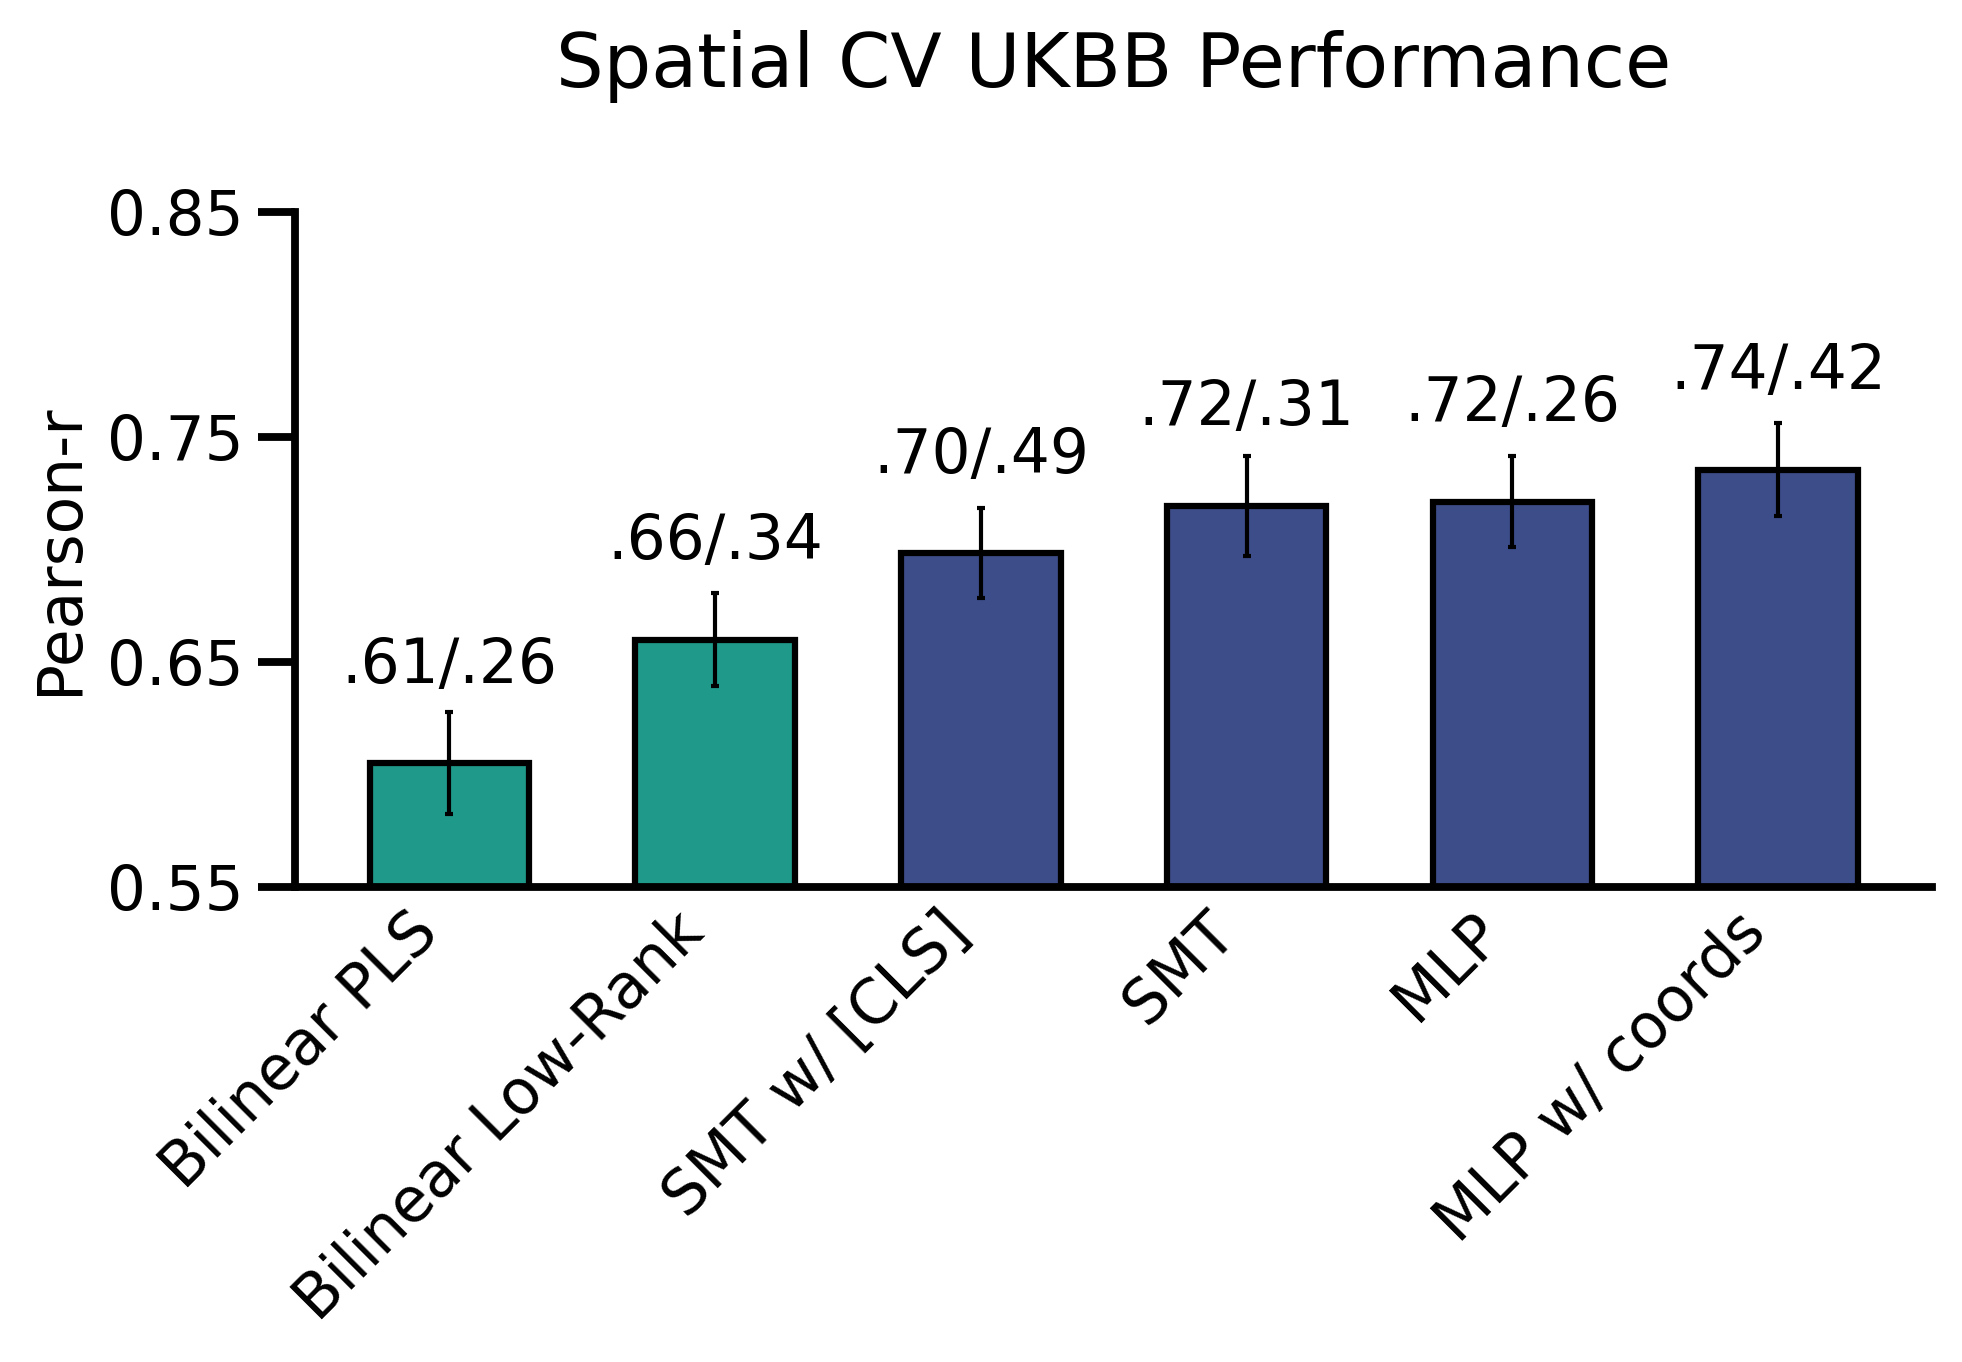

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253)}

In [77]:
plot_final_subsetted_barchart(
    summary_true_dict=summary_dict_spatial,        # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_spatial_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    ylim=(0.55, .85),
    overlay_style='ratio',                          # or 'alpha'
    #display_metric=False,
    title="Spatial CV UKBB Performance",
    horizontal=True
)

Build table with all relevant metrics

In [12]:
summary_dict_spatial

{'cge':         train_geodesic_distance  train_inter_hemi_r  \
 mean                  22.708445            0.211864   
 std                    1.461010            0.030277   
 stderr                 0.231006            0.004787   
 
         train_inter_network_Cerebellum_r  train_inter_network_Cont_r  \
 mean                            0.146449                    0.190234   
 std                             0.100003                    0.058859   
 stderr                          0.016667                    0.009306   
 
         train_inter_network_Default_r  train_inter_network_DorsAttn_r  \
 mean                         0.153695                        0.198619   
 std                          0.098545                        0.046692   
 stderr                       0.015581                        0.007383   
 
         train_inter_network_Limbic_r  train_inter_network_SalVentAttn_r  \
 mean                        0.218079                           0.157458   
 std                   

In [13]:
def create_test_metric_dataframes(summary_dict):
    # Initialize empty lists for global and subnetwork metrics
    global_metrics = []
    subnetwork_metrics = []
    
    # Define global metric columns
    global_cols = ['pearson_r', 'r2', 'short_r', 'mid_r', 'long_r',
                  'strong_pos_r', 'strong_neg_r', 'weak_r',
                  'left_hemi_r', 'right_hemi_r', 'inter_hemi_r',
                  'mse', 'geodesic_distance']
                  
    # Define subnetworks
    networks = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 
                'Cont', 'Default', 'Subcortical', 'Cerebellum']
    
    # Process each model
    model_order = ['shared_transformer_cls', 'dynamic_mlp_coords', 'shared_transformer', 'dynamic_mlp']
    remaining_models = [m for m in reversed(summary_dict.keys()) if m not in model_order]
    ordered_models = model_order + remaining_models
    
    for model in ordered_models:
        if model not in summary_dict:
            continue
            
        df = summary_dict[model]
        
        # Global metrics
        global_row = {}
        for col in global_cols:
            mean = df.loc['mean', f'test_{col}']
            std = df.loc['std', f'test_{col}']
            global_row[col] = f"{mean:.3f} ± {std:.3f}"
        global_metrics.append({'Model': model, **global_row})
        
        # Subnetwork metrics  
        subnetwork_row = {'Model': model}
        for network in networks:
            # Intra-network correlation
            intra_mean = df.loc['mean', f'test_intra_network_{network}_r']
            intra_std = df.loc['std', f'test_intra_network_{network}_r']
            subnetwork_row[f'{network} Intra'] = f"{intra_mean:.3f} ± {intra_std:.3f}"
            
            # Inter-network correlation
            inter_mean = df.loc['mean', f'test_inter_network_{network}_r'] 
            inter_std = df.loc['std', f'test_inter_network_{network}_r']
            subnetwork_row[f'{network} Inter'] = f"{inter_mean:.3f} ± {inter_std:.3f}"
            
        subnetwork_metrics.append(subnetwork_row)
    
    # Create dataframes
    global_df = pd.DataFrame(global_metrics).set_index('Model')
    subnetwork_df = pd.DataFrame(subnetwork_metrics).set_index('Model')
    
    return global_df, subnetwork_df

In [14]:
# Create the dataframes for random
global_metrics_df_random, subnetwork_metrics_df_random = create_test_metric_dataframes(summary_dict_random)

print("\nRandom Test Metrics:")
print("\nGlobal Test Metrics:")
display(global_metrics_df_random)
print("\nSubnetwork Test Metrics:") 
display(subnetwork_metrics_df_random)

# Create the dataframes for random
global_metrics_df_random_spin, subnetwork_metrics_df_random_spin = create_test_metric_dataframes(summary_dict_random_spin)

print("\nRandom Test Spin Metrics:")
print("\nGlobal Test  Spin Metrics:")
display(global_metrics_df_random_spin)


Random Test Metrics:

Global Test Metrics:


,pearson_r,r2,short_r,mid_r,long_r,strong_pos_r,strong_neg_r,weak_r,left_hemi_r,right_hemi_r,inter_hemi_r,mse,geodesic_distance
Model,,,,,,,,,,,,,
shared_transformer_cls,0.843 ± 0.021,0.705 ± 0.039,0.861 ± 0.019,0.819 ± 0.027,0.783 ± 0.057,0.550 ± 0.060,0.248 ± 0.124,0.748 ± 0.033,0.828 ± 0.034,0.862 ± 0.025,0.841 ± 0.024,0.010 ± 0.001,9.710 ± 0.857
dynamic_mlp_coords,0.826 ± 0.027,0.674 ± 0.050,0.847 ± 0.026,0.799 ± 0.032,0.752 ± 0.064,0.532 ± 0.072,0.157 ± 0.128,0.729 ± 0.035,0.816 ± 0.036,0.846 ± 0.034,0.821 ± 0.031,0.011 ± 0.001,9.591 ± 0.783
shared_transformer,0.793 ± 0.029,0.614 ± 0.055,0.824 ± 0.027,0.763 ± 0.033,0.689 ± 0.072,0.480 ± 0.070,0.139 ± 0.124,0.686 ± 0.034,0.779 ± 0.041,0.831 ± 0.033,0.785 ± 0.033,0.013 ± 0.001,10.219 ± 0.986
dynamic_mlp,0.781 ± 0.029,0.587 ± 0.054,0.816 ± 0.027,0.748 ± 0.033,0.668 ± 0.060,0.479 ± 0.076,0.095 ± 0.124,0.669 ± 0.036,0.785 ± 0.038,0.809 ± 0.040,0.766 ± 0.035,0.014 ± 0.001,10.249 ± 1.074
bilinear_lowrank,0.772 ± 0.029,0.594 ± 0.044,0.798 ± 0.025,0.741 ± 0.035,0.695 ± 0.060,0.399 ± 0.066,0.086 ± 0.121,0.682 ± 0.040,0.754 ± 0.046,0.803 ± 0.033,0.771 ± 0.031,0.014 ± 0.001,11.183 ± 1.103
pls_bilineardecoder,0.720 ± 0.079,0.517 ± 0.103,0.754 ± 0.078,0.678 ± 0.089,0.626 ± 0.109,0.370 ± 0.096,0.058 ± 0.125,0.621 ± 0.081,0.703 ± 0.089,0.749 ± 0.077,0.718 ± 0.078,0.016 ± 0.004,11.956 ± 1.929
bilinear_CM_PCA,0.506 ± 0.037,0.239 ± 0.077,0.567 ± 0.048,0.429 ± 0.039,0.347 ± 0.069,0.306 ± 0.078,0.019 ± 0.117,0.374 ± 0.034,0.490 ± 0.052,0.553 ± 0.047,0.498 ± 0.042,0.025 ± 0.003,15.302 ± 0.639
bilinear_CM,0.617 ± 0.095,0.093 ± 0.396,0.629 ± 0.118,0.592 ± 0.091,0.552 ± 0.089,0.223 ± 0.103,0.082 ± 0.119,0.528 ± 0.089,0.652 ± 0.084,0.687 ± 0.076,0.583 ± 0.113,0.030 ± 0.012,16.070 ± 1.388
exponential_decay,0.346 ± 0.028,0.117 ± 0.022,0.411 ± 0.038,0.070 ± 0.032,0.095 ± 0.069,0.338 ± 0.045,0.113 ± 0.091,0.195 ± 0.024,0.399 ± 0.048,0.428 ± 0.045,0.242 ± 0.044,0.030 ± 0.003,15.667 ± 0.711



Subnetwork Test Metrics:


,Vis Intra,Vis Inter,SomMot Intra,SomMot Inter,DorsAttn Intra,DorsAttn Inter,SalVentAttn Intra,SalVentAttn Inter,Limbic Intra,Limbic Inter,Cont Intra,Cont Inter,Default Intra,Default Inter,Subcortical Intra,Subcortical Inter,Cerebellum Intra,Cerebellum Inter
Model,,,,,,,,,,,,,,,,,,
shared_transformer_cls,0.887 ± 0.059,0.872 ± 0.025,0.879 ± 0.059,0.875 ± 0.029,0.859 ± 0.079,0.875 ± 0.027,0.852 ± 0.090,0.865 ± 0.028,0.853 ± 0.152,0.866 ± 0.030,0.837 ± 0.103,0.852 ± 0.040,0.804 ± 0.081,0.841 ± 0.034,0.793 ± 0.113,0.855 ± 0.028,0.594 ± 0.578,0.851 ± 0.034
dynamic_mlp_coords,0.880 ± 0.054,0.866 ± 0.024,0.870 ± 0.055,0.866 ± 0.029,0.843 ± 0.114,0.866 ± 0.030,0.854 ± 0.084,0.860 ± 0.031,0.845 ± 0.145,0.858 ± 0.035,0.825 ± 0.106,0.847 ± 0.040,0.824 ± 0.060,0.840 ± 0.029,0.774 ± 0.121,0.843 ± 0.029,0.603 ± 0.527,0.840 ± 0.043
shared_transformer,0.871 ± 0.056,0.841 ± 0.025,0.843 ± 0.073,0.846 ± 0.032,0.826 ± 0.132,0.844 ± 0.036,0.816 ± 0.144,0.832 ± 0.039,0.842 ± 0.126,0.831 ± 0.044,0.793 ± 0.096,0.812 ± 0.044,0.792 ± 0.064,0.811 ± 0.030,0.675 ± 0.205,0.805 ± 0.034,0.694 ± 0.381,0.807 ± 0.043
dynamic_mlp,0.858 ± 0.067,0.834 ± 0.027,0.836 ± 0.064,0.839 ± 0.032,0.808 ± 0.144,0.840 ± 0.040,0.815 ± 0.167,0.829 ± 0.039,0.822 ± 0.172,0.826 ± 0.047,0.783 ± 0.104,0.808 ± 0.043,0.782 ± 0.073,0.804 ± 0.033,0.654 ± 0.259,0.799 ± 0.038,0.524 ± 0.516,0.791 ± 0.058
bilinear_lowrank,0.838 ± 0.065,0.818 ± 0.027,0.821 ± 0.061,0.827 ± 0.031,0.803 ± 0.137,0.830 ± 0.039,0.788 ± 0.136,0.812 ± 0.045,0.803 ± 0.156,0.816 ± 0.040,0.766 ± 0.148,0.799 ± 0.049,0.773 ± 0.066,0.793 ± 0.033,0.680 ± 0.199,0.795 ± 0.034,0.543 ± 0.691,0.789 ± 0.051
pls_bilineardecoder,0.794 ± 0.085,0.770 ± 0.072,0.774 ± 0.100,0.782 ± 0.074,0.767 ± 0.153,0.789 ± 0.064,0.742 ± 0.198,0.771 ± 0.083,0.781 ± 0.218,0.779 ± 0.066,0.721 ± 0.163,0.751 ± 0.077,0.723 ± 0.083,0.740 ± 0.082,0.619 ± 0.195,0.744 ± 0.076,0.829 ± 0.367,0.735 ± 0.089
bilinear_CM_PCA,0.603 ± 0.125,0.566 ± 0.055,0.570 ± 0.129,0.573 ± 0.069,0.598 ± 0.224,0.598 ± 0.070,0.559 ± 0.174,0.586 ± 0.060,0.635 ± 0.255,0.590 ± 0.082,0.497 ± 0.239,0.538 ± 0.085,0.433 ± 0.126,0.508 ± 0.064,0.399 ± 0.225,0.510 ± 0.056,0.038 ± 0.852,0.495 ± 0.086
bilinear_CM,0.727 ± 0.115,0.682 ± 0.088,0.658 ± 0.136,0.684 ± 0.103,0.653 ± 0.201,0.690 ± 0.100,0.647 ± 0.214,0.667 ± 0.105,0.712 ± 0.231,0.679 ± 0.090,0.658 ± 0.145,0.663 ± 0.097,0.620 ± 0.151,0.639 ± 0.093,0.472 ± 0.304,0.648 ± 0.087,0.109 ± 0.726,0.646 ± 0.096
exponential_decay,0.497 ± 0.156,0.332 ± 0.092,0.332 ± 0.144,0.356 ± 0.057,0.089 ± 0.226,0.313 ± 0.073,0.299 ± 0.261,0.340 ± 0.061,0.200 ± 0.390,0.349 ± 0.080,0.217 ± 0.224,0.322 ± 0.074,0.298 ± 0.160,0.281 ± 0.043,0.235 ± 0.325,0.294 ± 0.064,0.195 ± 0.807,0.276 ± 0.068



Random Test Spin Metrics:

Global Test  Spin Metrics:


,pearson_r,r2,short_r,mid_r,long_r,strong_pos_r,strong_neg_r,weak_r,left_hemi_r,right_hemi_r,inter_hemi_r,mse,geodesic_distance
Model,,,,,,,,,,,,,
shared_transformer_cls,0.732 ± 0.050,0.502 ± 0.089,0.759 ± 0.051,0.687 ± 0.057,0.666 ± 0.079,0.460 ± 0.075,0.164 ± 0.126,0.608 ± 0.060,0.705 ± 0.074,0.757 ± 0.058,0.731 ± 0.054,0.017 ± 0.003,11.611 ± 0.985
dynamic_mlp_coords,0.483 ± 0.088,0.132 ± 0.139,0.498 ± 0.093,0.410 ± 0.090,0.370 ± 0.125,0.318 ± 0.060,0.057 ± 0.135,0.356 ± 0.086,0.460 ± 0.102,0.501 ± 0.096,0.482 ± 0.087,0.029 ± 0.006,14.022 ± 0.812
shared_transformer,0.343 ± 0.086,-0.115 ± 0.149,0.344 ± 0.089,0.288 ± 0.085,0.280 ± 0.113,0.174 ± 0.071,0.048 ± 0.131,0.252 ± 0.071,0.341 ± 0.100,0.355 ± 0.096,0.340 ± 0.087,0.038 ± 0.006,15.223 ± 1.430
dynamic_mlp,0.286 ± 0.086,-0.260 ± 0.158,0.299 ± 0.084,0.234 ± 0.084,0.223 ± 0.114,0.153 ± 0.073,0.019 ± 0.139,0.207 ± 0.071,0.276 ± 0.098,0.303 ± 0.100,0.284 ± 0.087,0.042 ± 0.006,15.847 ± 1.692
bilinear_lowrank,0.415 ± 0.072,0.141 ± 0.071,0.420 ± 0.069,0.347 ± 0.079,0.346 ± 0.103,0.218 ± 0.077,0.028 ± 0.120,0.306 ± 0.069,0.403 ± 0.079,0.427 ± 0.088,0.416 ± 0.073,0.029 ± 0.003,16.032 ± 1.392
pls_bilineardecoder,0.330 ± 0.081,0.075 ± 0.086,0.334 ± 0.092,0.258 ± 0.084,0.267 ± 0.096,0.188 ± 0.085,-0.005 ± 0.120,0.239 ± 0.066,0.325 ± 0.082,0.338 ± 0.102,0.329 ± 0.086,0.031 ± 0.004,19.310 ± 3.827
bilinear_CM_PCA,0.315 ± 0.063,0.087 ± 0.053,0.337 ± 0.070,0.217 ± 0.068,0.240 ± 0.071,0.273 ± 0.074,0.011 ± 0.108,0.202 ± 0.046,0.306 ± 0.081,0.329 ± 0.077,0.314 ± 0.061,0.031 ± 0.003,18.765 ± 1.107
bilinear_CM,0.205 ± 0.083,-1.480 ± 0.997,0.222 ± 0.082,0.160 ± 0.077,0.153 ± 0.104,0.101 ± 0.076,0.004 ± 0.133,0.142 ± 0.069,0.199 ± 0.095,0.236 ± 0.093,0.191 ± 0.083,0.083 ± 0.031,18.212 ± 0.972
exponential_decay,0.346 ± 0.027,0.117 ± 0.021,0.411 ± 0.038,0.071 ± 0.032,0.094 ± 0.059,0.338 ± 0.043,0.114 ± 0.092,0.195 ± 0.025,0.398 ± 0.049,0.428 ± 0.047,0.244 ± 0.044,0.030 ± 0.003,15.622 ± 0.835


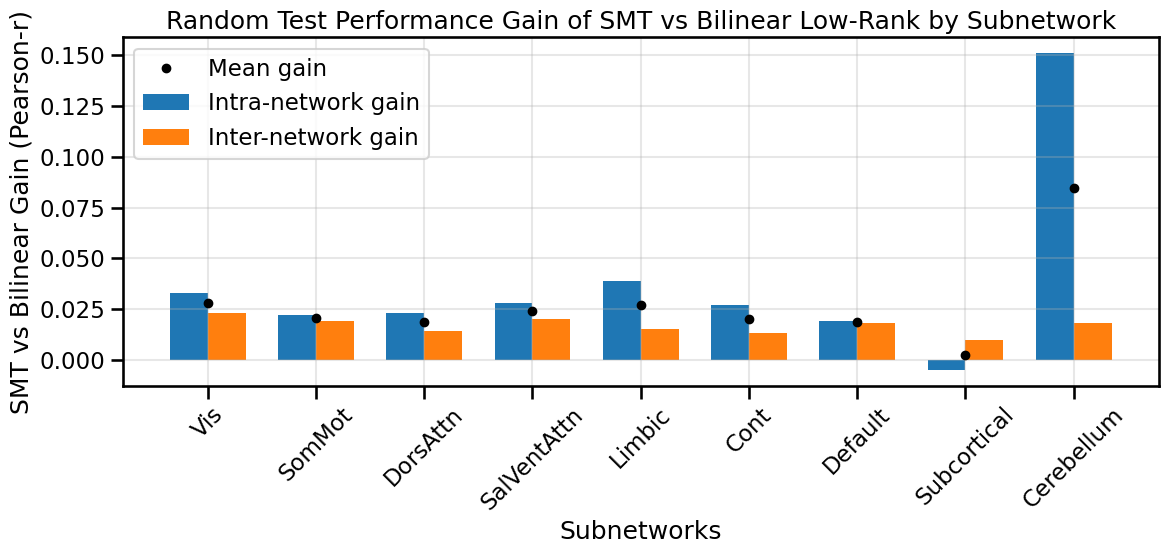

In [15]:
# Extract metrics for shared_transformer and bilinear_lowrank
smt_metrics_random = subnetwork_metrics_df_random.loc['shared_transformer']
blr_metrics_random = subnetwork_metrics_df_random.loc['bilinear_lowrank']

# Calculate gains for each subnetwork
networks = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default', 'Subcortical', 'Cerebellum']
gains_random = {'Intra': [], 'Inter': []}

for network in networks:
    # Extract values from string format "mean ± std"
    smt_intra = float(smt_metrics_random[f'{network} Intra'].split('±')[0])
    blr_intra = float(blr_metrics_random[f'{network} Intra'].split('±')[0])
    smt_inter = float(smt_metrics_random[f'{network} Inter'].split('±')[0])
    blr_inter = float(blr_metrics_random[f'{network} Inter'].split('±')[0])
    
    # Calculate gains
    gains_random['Intra'].append(smt_intra - blr_intra)
    gains_random['Inter'].append(smt_inter - blr_inter)

# Plot the per-subnetwork gains
plt.figure(figsize=(12, 6))
x = np.arange(len(networks))
width = 0.35

plt.bar(x - width/2, gains_random['Intra'], width, label='Intra-network gain')
plt.bar(x + width/2, gains_random['Inter'], width, label='Inter-network gain')

# Calculate and plot mean gains per subnetwork
subnetwork_mean_gains = []
for i in range(len(networks)):
    subnetwork_mean = (gains_random['Intra'][i] + gains_random['Inter'][i]) / 2
    subnetwork_mean_gains.append(subnetwork_mean)
    
# Add mean gain points
plt.plot(x, subnetwork_mean_gains, 'ko', markersize=6, label='Mean gain')

plt.xlabel('Subnetworks')
plt.ylabel('SMT vs Bilinear Gain (Pearson-r)')
plt.title('Random Test Performance Gain of SMT vs Bilinear Low-Rank by Subnetwork')
plt.xticks(x, networks, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
# Create the dataframes for spatial
global_metrics_df_spatial, subnetwork_metrics_df_spatial = create_test_metric_dataframes(summary_dict_spatial)

print("Spatial Test Metrics:")
print("\nGlobal Test Metrics:")
display(global_metrics_df_spatial)
print("\nSubnetwork Test Metrics:") 
display(subnetwork_metrics_df_spatial)


# Create the dataframes for random
global_metrics_df_spatial_spin, subnetwork_metrics_df_spatial_spin = create_test_metric_dataframes(summary_dict_spatial_spin)

print("\nSpatial Test Spin Metrics:")
print("\nGlobal Test  Spin Metrics:")
display(global_metrics_df_spatial_spin)


Spatial Test Metrics:

Global Test Metrics:


,pearson_r,r2,short_r,mid_r,long_r,strong_pos_r,strong_neg_r,weak_r,left_hemi_r,right_hemi_r,inter_hemi_r,mse,geodesic_distance
Model,,,,,,,,,,,,,
shared_transformer_cls,0.696 ± 0.123,0.388 ± 0.351,0.697 ± 0.135,0.612 ± 0.130,0.533 ± 0.254,0.407 ± 0.131,0.071 ± 0.198,0.536 ± 0.126,0.674 ± 0.159,0.708 ± 0.177,0.614 ± 0.204,0.025 ± 0.012,11.063 ± 1.946
dynamic_mlp_coords,0.735 ± 0.131,0.486 ± 0.293,0.736 ± 0.145,0.663 ± 0.137,0.579 ± 0.221,0.461 ± 0.118,0.074 ± 0.183,0.583 ± 0.144,0.711 ± 0.140,0.734 ± 0.160,0.656 ± 0.156,0.021 ± 0.011,10.328 ± 2.072
shared_transformer,0.716 ± 0.131,0.464 ± 0.263,0.718 ± 0.145,0.644 ± 0.140,0.487 ± 0.267,0.398 ± 0.109,0.094 ± 0.203,0.572 ± 0.142,0.679 ± 0.193,0.712 ± 0.181,0.622 ± 0.172,0.022 ± 0.010,10.836 ± 1.734
dynamic_mlp,0.721 ± 0.129,0.442 ± 0.320,0.727 ± 0.138,0.643 ± 0.136,0.498 ± 0.264,0.430 ± 0.113,0.081 ± 0.187,0.567 ± 0.146,0.703 ± 0.136,0.729 ± 0.140,0.624 ± 0.173,0.023 ± 0.012,10.506 ± 1.898
bilinear_lowrank,0.669 ± 0.131,0.424 ± 0.212,0.677 ± 0.147,0.571 ± 0.152,0.406 ± 0.282,0.358 ± 0.097,0.028 ± 0.179,0.532 ± 0.143,0.641 ± 0.140,0.654 ± 0.169,0.583 ± 0.163,0.024 ± 0.009,12.731 ± 2.882
pls_bilineardecoder,0.605 ± 0.143,0.315 ± 0.270,0.618 ± 0.155,0.492 ± 0.170,0.397 ± 0.233,0.318 ± 0.111,0.004 ± 0.163,0.471 ± 0.145,0.589 ± 0.183,0.591 ± 0.188,0.539 ± 0.175,0.027 ± 0.009,13.746 ± 3.126
bilinear_CM_PCA,0.423 ± 0.154,-1.139 ± 3.130,0.422 ± 0.166,0.294 ± 0.135,0.198 ± 0.236,0.217 ± 0.119,-0.020 ± 0.113,0.284 ± 0.112,0.421 ± 0.166,0.439 ± 0.198,0.387 ± 0.181,0.075 ± 0.086,16.290 ± 2.121
bilinear_CM,0.456 ± 0.250,-0.876 ± 2.719,0.444 ± 0.272,0.443 ± 0.192,0.260 ± 0.225,0.157 ± 0.203,0.022 ± 0.158,0.375 ± 0.210,0.395 ± 0.268,0.419 ± 0.271,0.282 ± 0.239,0.073 ± 0.078,16.983 ± 2.264
exponential_decay,0.441 ± 0.058,0.153 ± 0.087,0.445 ± 0.059,0.080 ± 0.080,-0.006 ± 0.125,0.356 ± 0.090,0.074 ± 0.135,0.236 ± 0.038,0.489 ± 0.098,0.497 ± 0.125,0.366 ± 0.131,0.036 ± 0.009,14.015 ± 1.310



Subnetwork Test Metrics:


,Vis Intra,Vis Inter,SomMot Intra,SomMot Inter,DorsAttn Intra,DorsAttn Inter,SalVentAttn Intra,SalVentAttn Inter,Limbic Intra,Limbic Inter,Cont Intra,Cont Inter,Default Intra,Default Inter,Subcortical Intra,Subcortical Inter,Cerebellum Intra,Cerebellum Inter
Model,,,,,,,,,,,,,,,,,,
shared_transformer_cls,0.696 ± 0.159,0.699 ± 0.112,0.741 ± 0.112,0.702 ± 0.116,0.674 ± 0.218,0.678 ± 0.137,0.687 ± 0.176,0.669 ± 0.152,0.707 ± 0.242,0.664 ± 0.160,0.625 ± 0.204,0.651 ± 0.150,0.657 ± 0.154,0.669 ± 0.137,0.693 ± 0.208,0.672 ± 0.144,0.593 ± 0.290,0.679 ± 0.157
dynamic_mlp_coords,0.757 ± 0.140,0.757 ± 0.116,0.778 ± 0.110,0.754 ± 0.115,0.734 ± 0.310,0.728 ± 0.150,0.719 ± 0.194,0.715 ± 0.169,0.714 ± 0.272,0.716 ± 0.174,0.669 ± 0.195,0.698 ± 0.160,0.713 ± 0.164,0.716 ± 0.157,0.664 ± 0.342,0.724 ± 0.160,0.539 ± 0.384,0.745 ± 0.113
shared_transformer,0.752 ± 0.135,0.744 ± 0.109,0.758 ± 0.120,0.734 ± 0.116,0.727 ± 0.276,0.712 ± 0.157,0.702 ± 0.197,0.697 ± 0.164,0.695 ± 0.338,0.693 ± 0.164,0.658 ± 0.206,0.682 ± 0.157,0.688 ± 0.151,0.700 ± 0.151,0.665 ± 0.276,0.701 ± 0.160,0.517 ± 0.480,0.728 ± 0.106
dynamic_mlp,0.750 ± 0.130,0.750 ± 0.112,0.753 ± 0.135,0.739 ± 0.117,0.724 ± 0.329,0.715 ± 0.151,0.700 ± 0.191,0.706 ± 0.160,0.703 ± 0.327,0.711 ± 0.160,0.655 ± 0.198,0.690 ± 0.149,0.701 ± 0.153,0.705 ± 0.147,0.673 ± 0.325,0.711 ± 0.154,0.480 ± 0.442,0.730 ± 0.103
bilinear_lowrank,0.597 ± 0.159,0.584 ± 0.147,0.551 ± 0.208,0.697 ± 0.110,0.513 ± 0.355,0.620 ± 0.155,0.594 ± 0.283,0.636 ± 0.161,0.432 ± 0.444,0.591 ± 0.156,0.557 ± 0.231,0.593 ± 0.164,0.621 ± 0.129,0.582 ± 0.180,0.599 ± 0.273,0.617 ± 0.164,0.332 ± 0.448,0.316 ± 0.490
pls_bilineardecoder,0.528 ± 0.257,0.549 ± 0.187,0.496 ± 0.246,0.613 ± 0.152,0.448 ± 0.407,0.546 ± 0.193,0.548 ± 0.308,0.564 ± 0.188,0.556 ± 0.372,0.562 ± 0.170,0.520 ± 0.242,0.524 ± 0.197,0.562 ± 0.159,0.519 ± 0.196,0.577 ± 0.214,0.481 ± 0.256,0.333 ± 0.411,0.370 ± 0.386
bilinear_CM_PCA,0.394 ± 0.190,0.317 ± 0.179,0.348 ± 0.201,0.440 ± 0.159,0.451 ± 0.205,0.331 ± 0.152,0.447 ± 0.284,0.356 ± 0.163,0.338 ± 0.241,0.294 ± 0.194,0.421 ± 0.182,0.405 ± 0.146,0.416 ± 0.143,0.321 ± 0.152,0.352 ± 0.254,0.317 ± 0.196,0.106 ± 0.375,0.195 ± 0.227
bilinear_CM,0.371 ± 0.371,0.417 ± 0.260,0.417 ± 0.348,0.505 ± 0.241,0.443 ± 0.384,0.459 ± 0.262,0.357 ± 0.400,0.456 ± 0.269,0.311 ± 0.479,0.420 ± 0.266,0.344 ± 0.311,0.391 ± 0.272,0.344 ± 0.315,0.396 ± 0.269,0.323 ± 0.383,0.385 ± 0.266,0.087 ± 0.517,0.202 ± 0.416
exponential_decay,0.422 ± 0.303,0.384 ± 0.089,0.455 ± 0.143,0.423 ± 0.080,0.351 ± 0.302,0.396 ± 0.081,0.472 ± 0.205,0.419 ± 0.089,0.442 ± 0.362,0.375 ± 0.088,0.458 ± 0.166,0.404 ± 0.085,0.447 ± 0.109,0.398 ± 0.082,0.377 ± 0.199,0.386 ± 0.089,0.330 ± 0.296,0.303 ± 0.194



Spatial Test Spin Metrics:

Global Test  Spin Metrics:


,pearson_r,r2,short_r,mid_r,long_r,strong_pos_r,strong_neg_r,weak_r,left_hemi_r,right_hemi_r,inter_hemi_r,mse,geodesic_distance
Model,,,,,,,,,,,,,
shared_transformer_cls,0.488 ± 0.133,0.006 ± 0.389,0.479 ± 0.139,0.359 ± 0.160,0.387 ± 0.120,0.286 ± 0.111,0.040 ± 0.170,0.322 ± 0.112,0.518 ± 0.171,0.556 ± 0.180,0.476 ± 0.229,0.041 ± 0.015,12.603 ± 1.456
dynamic_mlp_coords,0.421 ± 0.097,0.034 ± 0.202,0.403 ± 0.096,0.279 ± 0.100,0.209 ± 0.147,0.256 ± 0.094,0.041 ± 0.126,0.247 ± 0.074,0.427 ± 0.137,0.427 ± 0.260,0.410 ± 0.130,0.041 ± 0.011,14.099 ± 1.516
shared_transformer,0.301 ± 0.120,-0.135 ± 0.216,0.290 ± 0.118,0.206 ± 0.112,0.147 ± 0.122,0.128 ± 0.088,-0.013 ± 0.125,0.190 ± 0.092,0.284 ± 0.156,0.278 ± 0.215,0.245 ± 0.127,0.048 ± 0.014,15.172 ± 1.645
dynamic_mlp,0.261 ± 0.118,-0.258 ± 0.302,0.253 ± 0.114,0.171 ± 0.105,0.103 ± 0.075,0.106 ± 0.078,0.034 ± 0.104,0.160 ± 0.090,0.274 ± 0.161,0.268 ± 0.161,0.202 ± 0.122,0.053 ± 0.014,15.225 ± 1.624
bilinear_lowrank,0.336 ± 0.131,0.052 ± 0.158,0.327 ± 0.130,0.216 ± 0.126,0.170 ± 0.128,0.161 ± 0.081,0.022 ± 0.122,0.209 ± 0.111,0.332 ± 0.149,0.306 ± 0.224,0.276 ± 0.139,0.041 ± 0.011,16.566 ± 2.112
pls_bilineardecoder,0.259 ± 0.122,-0.011 ± 0.143,0.251 ± 0.124,0.142 ± 0.126,0.125 ± 0.083,0.139 ± 0.089,0.025 ± 0.116,0.147 ± 0.095,0.277 ± 0.177,0.251 ± 0.206,0.222 ± 0.144,0.044 ± 0.012,20.212 ± 4.200
bilinear_CM_PCA,0.249 ± 0.131,-1.167 ± 3.718,0.233 ± 0.135,0.128 ± 0.109,0.102 ± 0.131,0.153 ± 0.095,0.022 ± 0.127,0.136 ± 0.082,0.235 ± 0.183,0.269 ± 0.200,0.230 ± 0.148,0.072 ± 0.085,19.427 ± 2.003
bilinear_CM,0.152 ± 0.123,-2.315 ± 3.399,0.145 ± 0.126,0.099 ± 0.095,0.070 ± 0.061,0.052 ± 0.087,0.006 ± 0.115,0.098 ± 0.084,0.143 ± 0.137,0.125 ± 0.232,0.087 ± 0.108,0.119 ± 0.070,18.781 ± 1.931
exponential_decay,0.437 ± 0.060,0.147 ± 0.089,0.442 ± 0.057,0.078 ± 0.079,-0.008 ± 0.143,0.355 ± 0.087,0.078 ± 0.131,0.234 ± 0.040,0.484 ± 0.105,0.507 ± 0.148,0.361 ± 0.134,0.037 ± 0.009,14.097 ± 1.442


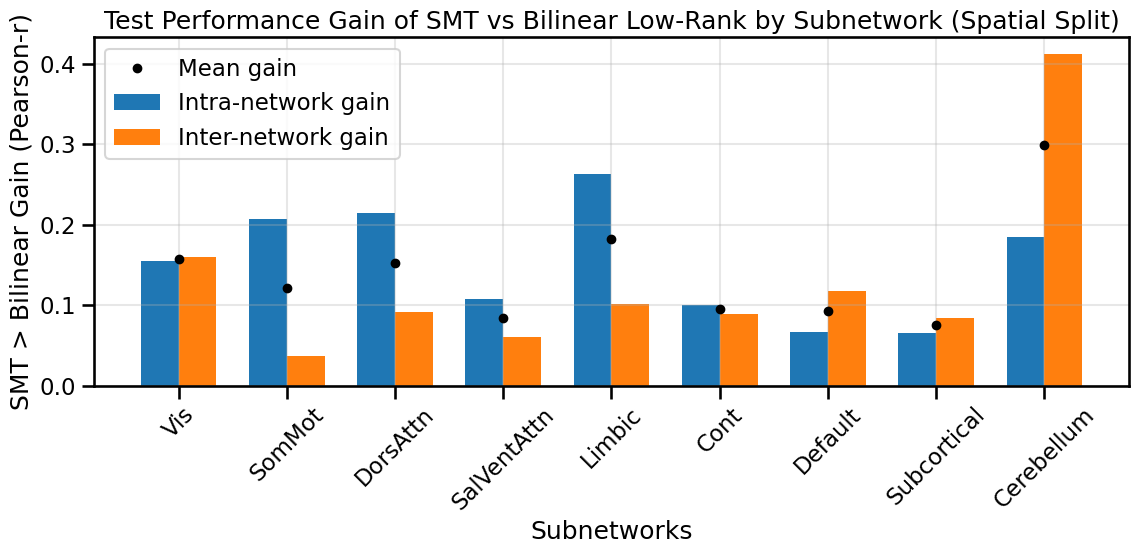

In [17]:
# Extract metrics for shared_transformer and bilinear_lowrank
smt_metrics = subnetwork_metrics_df_spatial.loc['shared_transformer']
blr_metrics = subnetwork_metrics_df_spatial.loc['bilinear_lowrank']

# Calculate gains for each subnetwork
networks = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default', 'Subcortical', 'Cerebellum']
gains = {'Intra': [], 'Inter': []}

for network in networks:
    # Extract values from string format "mean ± std"
    smt_intra = float(smt_metrics[f'{network} Intra'].split('±')[0])
    blr_intra = float(blr_metrics[f'{network} Intra'].split('±')[0])
    smt_inter = float(smt_metrics[f'{network} Inter'].split('±')[0])
    blr_inter = float(blr_metrics[f'{network} Inter'].split('±')[0])
    
    # Calculate gains
    gains['Intra'].append(smt_intra - blr_intra)
    gains['Inter'].append(smt_inter - blr_inter)

# Plot the per-subnetwork gains
plt.figure(figsize=(12, 6))
x = np.arange(len(networks))
width = 0.35

plt.bar(x - width/2, gains['Intra'], width, label='Intra-network gain')
plt.bar(x + width/2, gains['Inter'], width, label='Inter-network gain')

# Calculate and plot mean gains per subnetwork
subnetwork_mean_gains = []
for i in range(len(networks)):
    subnetwork_mean = (gains['Intra'][i] + gains['Inter'][i]) / 2
    subnetwork_mean_gains.append(subnetwork_mean)
    
# Add mean gain points
plt.plot(x, subnetwork_mean_gains, 'ko', markersize=6, label='Mean gain')

plt.xlabel('Subnetworks')
plt.ylabel('SMT > Bilinear Gain (Pearson-r)')
plt.title('Test Performance Gain of SMT vs Bilinear Low-Rank by Subnetwork (Spatial Split)')
plt.xticks(x, networks, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# Create dictionaries from the actual gains data
mean_gains = {}
intra_gains = {}
inter_gains = {}

for i, network in enumerate(networks):
    mean_gains[network] = (gains['Intra'][i] + gains['Inter'][i]) / 2
    intra_gains[network] = gains['Intra'][i]
    inter_gains[network] = gains['Inter'][i]

print("Mean gains:", mean_gains)
print("\nIntra-network gains:", intra_gains) 
print("\nInter-network gains:", inter_gains)

# Per subnetwork SMT > Bilinear gains
mean_gains = {
    'Vis': 0.088,
    'SomMot': 0.081, 
    'DorsAttn': 0.063,
    'SalVentAttn': 0.061,
    'Limbic': 0.044,
    'Cont': 0.054,
    'Default': 0.047,
    'Subcortical': 0.036,
    'Cerebellum': 0.058
}

intra_network_gains = {
    'Vis': 0.11,
    'SomMot': 0.11,
    'DorsAttn': 0.071,
    'SalVentAttn': 0.069,
    'Limbic': 0.035,
    'Cont': 0.057,
    'Default': 0.040,
    'Subcortical': 0.032,
    'Cerebellum': 0.035
}

inter_network_gains = {
    'Vis': 0.069,
    'SomMot': 0.056,
    'DorsAttn': 0.055,
    'SalVentAttn': 0.054,
    'Limbic': 0.054,
    'Cont': 0.051,
    'Default': 0.055,
    'Subcortical': 0.041,
    'Cerebellum': 0.082
}

Mean gains: {'Vis': 0.15750000000000003, 'SomMot': 0.122, 'DorsAttn': 0.15299999999999997, 'SalVentAttn': 0.08449999999999996, 'Limbic': 0.18249999999999997, 'Cont': 0.09500000000000003, 'Default': 0.09249999999999997, 'Subcortical': 0.07500000000000001, 'Cerebellum': 0.2985}

Intra-network gains: {'Vis': 0.15500000000000003, 'SomMot': 0.20699999999999996, 'DorsAttn': 0.21399999999999997, 'SalVentAttn': 0.10799999999999998, 'Limbic': 0.26299999999999996, 'Cont': 0.10099999999999998, 'Default': 0.06699999999999995, 'Subcortical': 0.06600000000000006, 'Cerebellum': 0.185}

Inter-network gains: {'Vis': 0.16000000000000003, 'SomMot': 0.03700000000000003, 'DorsAttn': 0.09199999999999997, 'SalVentAttn': 0.06099999999999994, 'Limbic': 0.10199999999999998, 'Cont': 0.08900000000000008, 'Default': 0.118, 'Subcortical': 0.08399999999999996, 'Cerebellum': 0.412}


In [19]:
from data.data_load import *

# Load necessary labeled data
X, valid_genes = load_transcriptome(parcellation='S456', gene_list='0.2', hemisphere='both', omit_subcortical=False, sort_genes='expression', impute_strategy='mirror_interpolate', return_valid_genes=True)
labels, network_labels = load_network_labels(parcellation='S456', hemisphere='both', omit_subcortical=False)
valid_indices = ~np.isnan(X).all(axis=1)
X_valid = X[valid_indices]
labels = [labels[i] for i in range(len(labels)) if valid_indices[i]]
network_labels = network_labels[valid_indices]
unique_networks = np.unique(network_labels)

# Create color mapping for networks
colors = plt.cm.rainbow(np.linspace(0.0, 1, len(unique_networks)+1))
network_colors = dict(zip(unique_networks, colors))

Resorting genes by expression level


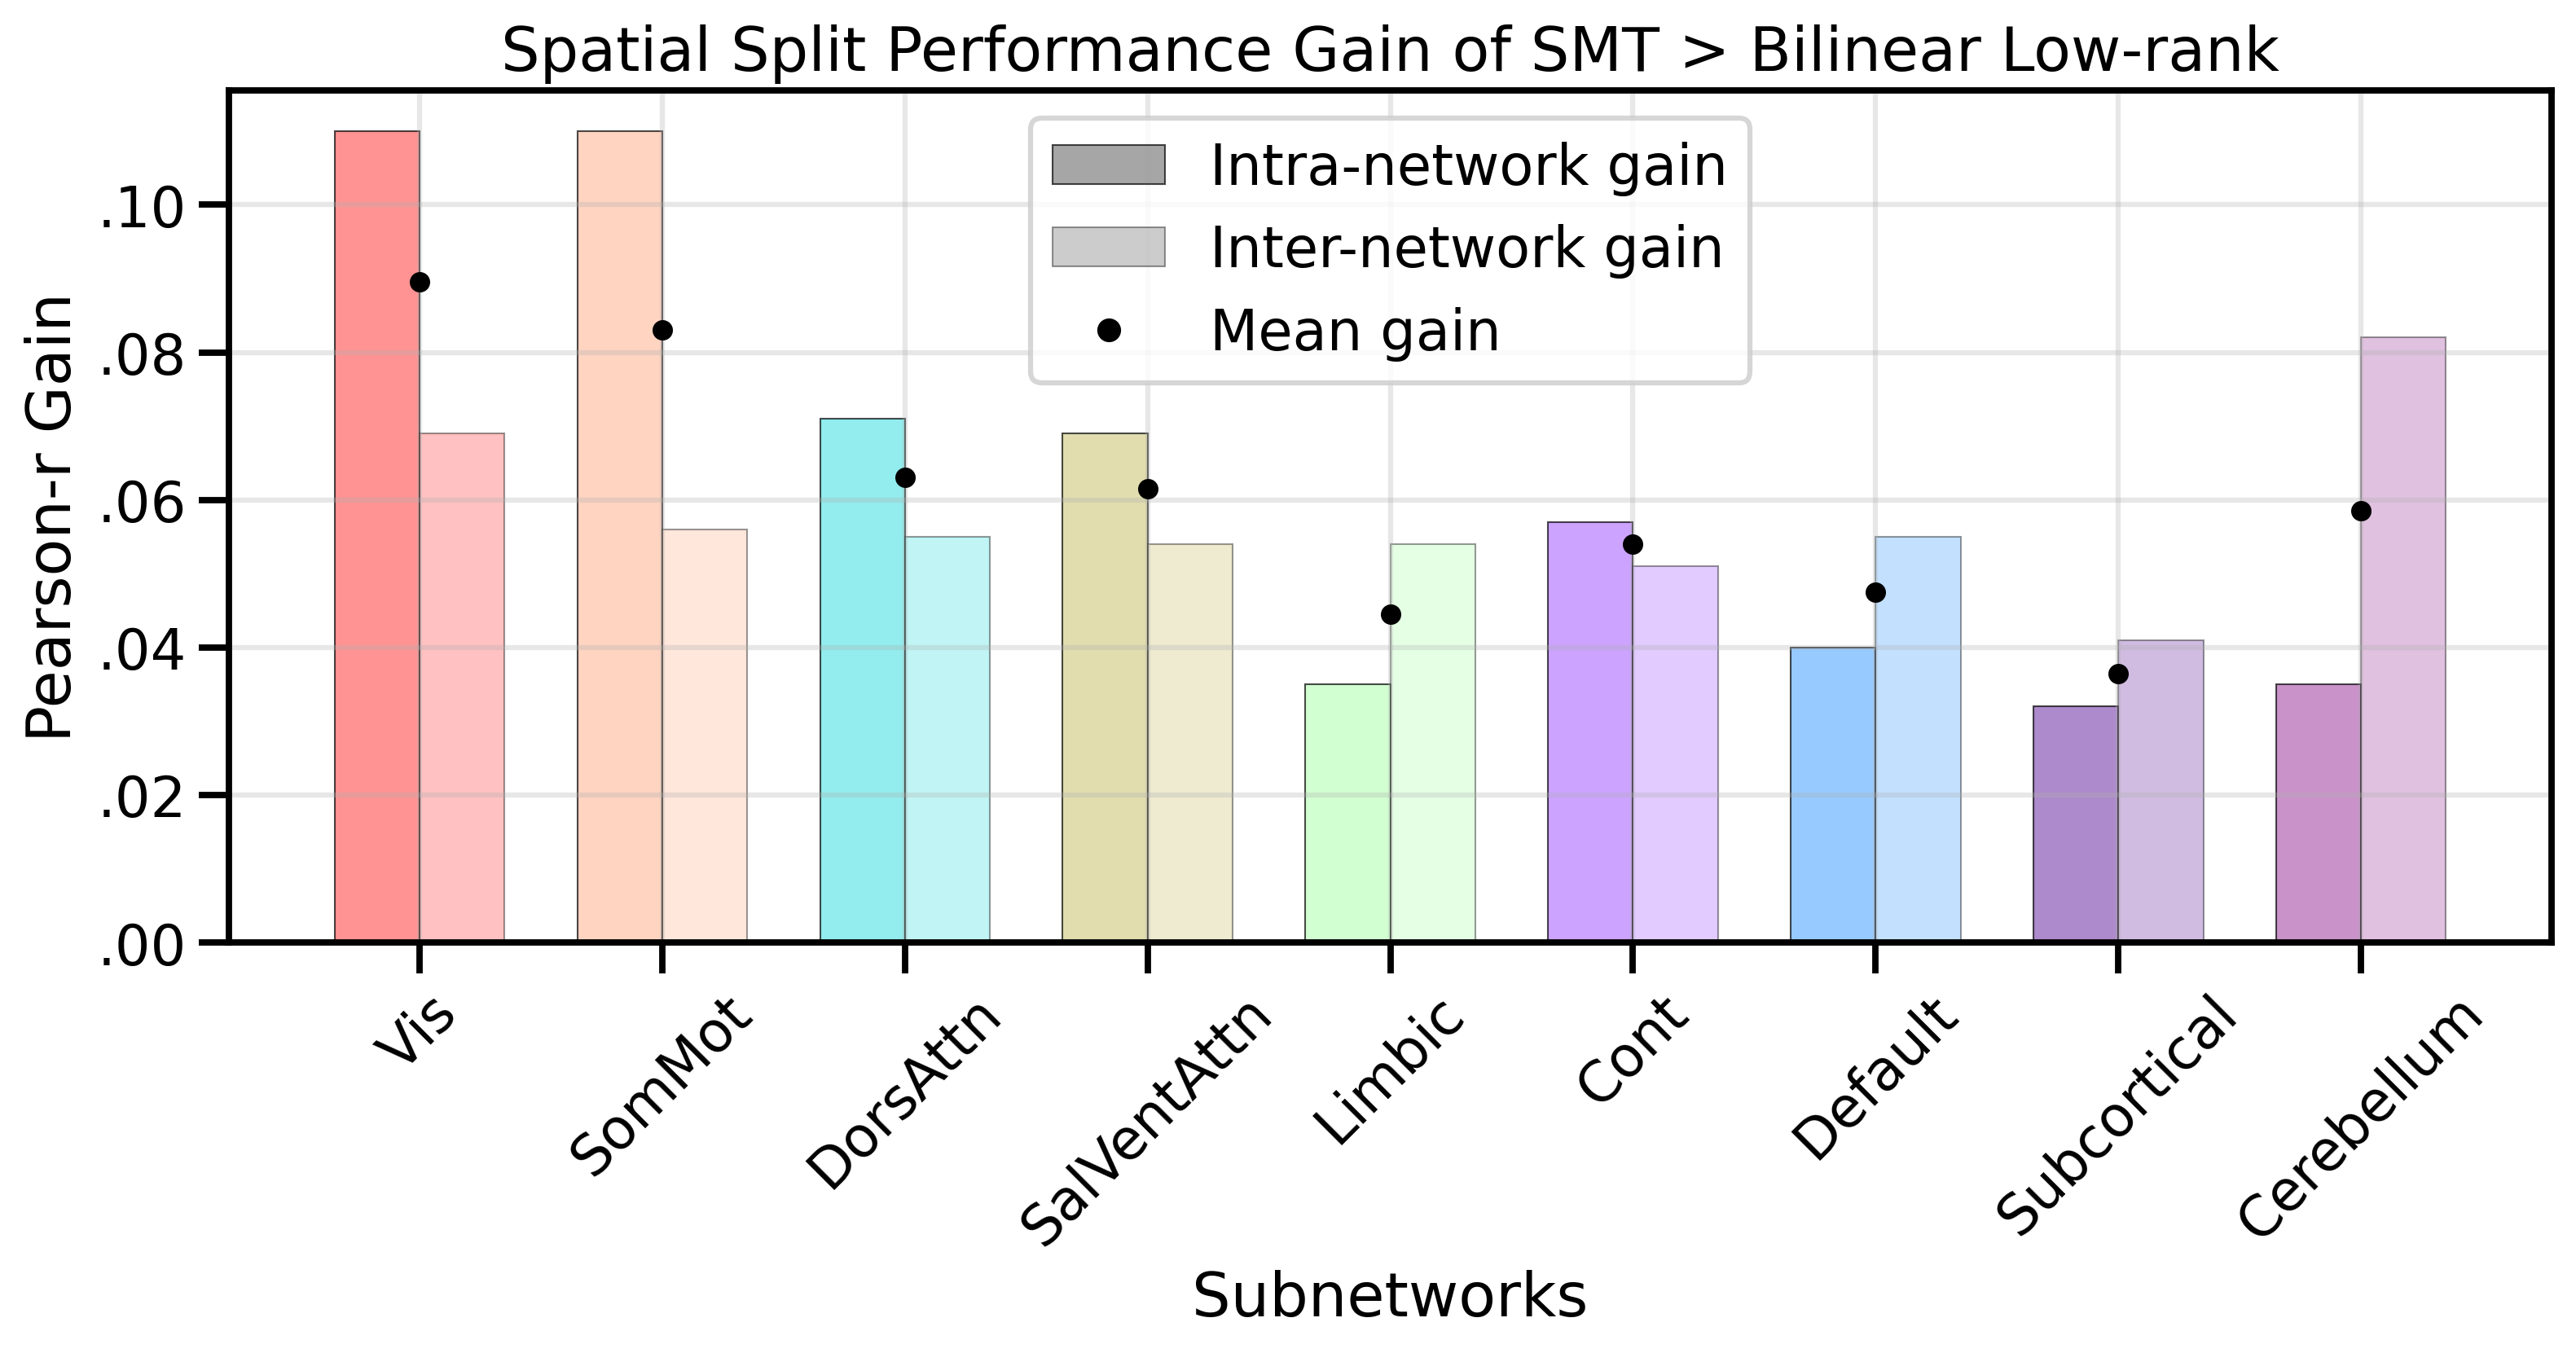

In [26]:
def plot_network_gains(subnetwork_metrics_df_spatial, network_colors, use_preloaded_gains=False):
    # Manual color mapping based on image with lighter colors
    network_colors = {
        'Cont': '#B77DFF',      # Lighter purple
        'Default': '#6BB5FF',   # Lighter blue  
        'DorsAttn': '#66E6E8',  # Lighter turquoise
        'Limbic': '#BFFFBF',    # Lighter green
        'SalVentAttn': '#D6CF8D', # Lighter khaki
        'SomMot': '#FFC4A8',    # Lighter salmon
        'Vis': '#FF6666',       # Lighter red
        'Cerebellum': '#B366B3', # Lighter dark purple
        'Subcortical': '#8B58B5' # Lighter indigo
    }

    # Define preloaded gains
    mean_gains = {
        'Vis': 0.088,
        'SomMot': 0.081, 
        'DorsAttn': 0.063,
        'SalVentAttn': 0.061,
        'Limbic': 0.044,
        'Cont': 0.054,
        'Default': 0.047,
        'Subcortical': 0.036,
        'Cerebellum': 0.058
    }

    intra_network_gains = {
        'Vis': 0.11,
        'SomMot': 0.11,
        'DorsAttn': 0.071,
        'SalVentAttn': 0.069,
        'Limbic': 0.035,
        'Cont': 0.057,
        'Default': 0.040,
        'Subcortical': 0.032,
        'Cerebellum': 0.035
    }

    inter_network_gains = {
        'Vis': 0.069,
        'SomMot': 0.056,
        'DorsAttn': 0.055,
        'SalVentAttn': 0.054,
        'Limbic': 0.054,
        'Cont': 0.051,
        'Default': 0.055,
        'Subcortical': 0.041,
        'Cerebellum': 0.082
    }

    networks = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default', 'Subcortical', 'Cerebellum']
    gains = {'Intra': [], 'Inter': []}

    if use_preloaded_gains:
        # Use preloaded gains from the dictionaries
        gains['Intra'] = [intra_network_gains[network] for network in networks]
        gains['Inter'] = [inter_network_gains[network] for network in networks]
    else:
        # Extract metrics for shared_transformer and bilinear_lowrank
        smt_metrics = subnetwork_metrics_df_spatial.loc['shared_transformer']
        blr_metrics = subnetwork_metrics_df_spatial.loc['bilinear_lowrank']

        for network in networks:
            # Extract values from string format "mean ± std"
            smt_intra = float(smt_metrics[f'{network} Intra'].split('±')[0])
            blr_intra = float(blr_metrics[f'{network} Intra'].split('±')[0])
            smt_inter = float(smt_metrics[f'{network} Inter'].split('±')[0])
            blr_inter = float(blr_metrics[f'{network} Inter'].split('±')[0])
            
            # Calculate gains
            gains['Intra'].append(smt_intra - blr_intra)
            gains['Inter'].append(smt_inter - blr_inter)

    # Plot the per-subnetwork gains
    plt.figure(figsize=(11, 6), dpi=300)  # Increased DPI to 300
    x = np.arange(len(networks))
    width = 0.35

    # Plot bars with network colors and black outline
    for i, network in enumerate(networks):
        plt.bar(x[i] - width/2, gains['Intra'][i], width, color=network_colors[network], 
                alpha=0.7, edgecolor='black', linewidth=0.5)
        plt.bar(x[i] + width/2, gains['Inter'][i], width, color=network_colors[network], 
                alpha=0.4, edgecolor='black', linewidth=0.5)

    # Calculate and plot mean gains per subnetwork
    subnetwork_mean_gains = []
    for i in range(len(networks)):
        subnetwork_mean = (gains['Intra'][i] + gains['Inter'][i]) / 2
        subnetwork_mean_gains.append(subnetwork_mean)
        
    # Add mean gain points
    plt.plot(x, subnetwork_mean_gains, 'ko', markersize=5, label='Mean gain')

    plt.xlabel('Subnetworks')
    plt.ylabel('Pearson-r Gain')
    plt.title('Spatial Split Performance Gain of SMT > Bilinear Low-rank')
    plt.xticks(x, networks, rotation=45)
    
    # Set y-axis ticks at 0.02 intervals and remove leading zeros
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.02))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'.lstrip('0')))
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='gray', alpha=0.7, label='Intra-network gain', edgecolor='black', linewidth=0.5),
        Patch(facecolor='gray', alpha=0.4, label='Inter-network gain', edgecolor='black', linewidth=0.5),
        plt.Line2D([0], [0], marker='o', color='k', label='Mean gain', 
                  markerfacecolor='k', markersize=6, linestyle='None')
    ]
    plt.legend(handles=legend_elements)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Call the function
plot_network_gains(subnetwork_metrics_df_spatial, network_colors, use_preloaded_gains=True)

Quick top 5 analysis

In [21]:
# Fetch data for top 5 models
summary_df_smt_cls, history_df_smt_cls = fetch_and_summarize_wandb_runs('shared_transformer_cls', 'spatial', 'none', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"SMT w/ [CLS]: {summary_df_smt_cls.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_smt_cls.loc['std', 'test_pearson_r']:.3f}")

summary_df_mlp_coords, history_df_mlp_coords = fetch_and_summarize_wandb_runs('dynamic_mlp', 'spatial', 'none', feature_type='transcriptome+euclidean', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"Deep Neural Net w/ coords: {summary_df_mlp_coords.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_mlp_coords.loc['std', 'test_pearson_r']:.3f}")

summary_df_smt, history_df_smt = fetch_and_summarize_wandb_runs('shared_transformer', 'spatial', 'none', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"SMT: {summary_df_smt.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_smt.loc['std', 'test_pearson_r']:.3f}")

summary_df_mlp, history_df_mlp = fetch_and_summarize_wandb_runs('dynamic_mlp', 'spatial', 'none', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"Deep Neural Net: {summary_df_mlp.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_mlp.loc['std', 'test_pearson_r']:.3f}")

summary_df_blr, history_df_blr = fetch_and_summarize_wandb_runs('bilinear_lowrank', 'spatial', 'none', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"Connectome Model (LR): {summary_df_blr.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_blr.loc['std', 'test_pearson_r']:.3f}")


# Fetch data for top 5 models
summary_df_smt_cls, history_df_smt_cls = fetch_and_summarize_wandb_runs('shared_transformer_cls', 'spatial', 'spin', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"SMT w/ [CLS]: {summary_df_smt_cls.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_smt_cls.loc['std', 'test_pearson_r']:.3f}")

summary_df_mlp_coords, history_df_mlp_coords = fetch_and_summarize_wandb_runs('dynamic_mlp', 'spatial', 'spin', feature_type='transcriptome+euclidean', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"Deep Neural Net w/ coords: {summary_df_mlp_coords.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_mlp_coords.loc['std', 'test_pearson_r']:.3f}")

summary_df_smt, history_df_smt = fetch_and_summarize_wandb_runs('shared_transformer', 'spatial', 'spin', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"SMT: {summary_df_smt.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_smt.loc['std', 'test_pearson_r']:.3f}")

summary_df_mlp, history_df_mlp = fetch_and_summarize_wandb_runs('dynamic_mlp', 'spatial', 'spin', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"Deep Neural Net: {summary_df_mlp.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_mlp.loc['std', 'test_pearson_r']:.3f}")

summary_df_blr, history_df_blr = fetch_and_summarize_wandb_runs('bilinear_lowrank', 'spatial', 'spin', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"Connectome Model (LR): {summary_df_blr.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_blr.loc['std', 'test_pearson_r']:.3f}")

🔍 Fetching runs for: model=shared_transformer_cls, cv_type=spatial, null_model=none, feature_type=transcriptome
SMT w/ [CLS]: 0.701 ± 0.122
🔍 Fetching runs for: model=dynamic_mlp, cv_type=spatial, null_model=none, feature_type=transcriptome+euclidean
Deep Neural Net w/ coords: 0.743 ± 0.122
🔍 Fetching runs for: model=shared_transformer, cv_type=spatial, null_model=none, feature_type=transcriptome
SMT: 0.733 ± 0.129
🔍 Fetching runs for: model=dynamic_mlp, cv_type=spatial, null_model=none, feature_type=transcriptome
Deep Neural Net: 0.723 ± 0.128
🔍 Fetching runs for: model=bilinear_lowrank, cv_type=spatial, null_model=none, feature_type=transcriptome


ValueError: ❌ Expected 40 runs, but found 0.

In [ ]:
summary_df_smt_cls, history_df_smt_cls = fetch_and_summarize_wandb_runs('shared_transformer_cls', 'spatial', 'none', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)

🔍 Fetching runs for: model=shared_transformer_cls, cv_type=spatial, null_model=none, feature_type=transcriptome


In [ ]:
summary_df_blr['test_pearson_r']

mean      0.668508
std       0.130789
stderr    0.020680
Name: test_pearson_r, dtype: float64

In [ ]:
history_df_blr['final_test_pearson_r'].tolist()

[0.8347339155528636,
 0.8293316597188712,
 0.8229584885401259,
 0.8205919515584069,
 0.8129796973768421,
 0.8095852691749817,
 0.8018394805117145,
 0.8015827346618584,
 0.7864373646313656,
 0.7771835462560556,
 0.7596221527792669,
 0.746183966891465,
 0.745757528346866,
 0.7447715113027605,
 0.7368192887778718,
 0.7247645641086932,
 0.70550815145401,
 0.6976743299161405,
 0.6944508516353926,
 0.6917002730991632,
 0.690614286818793,
 0.6779594303855898,
 0.6769683049236319,
 0.6624407158347838,
 0.6595185924316385,
 0.6570596993027024,
 0.6337032178850017,
 0.628525140202246,
 0.6255171302055681,
 0.6128468105773847,
 0.6123023884759752,
 0.5981953774938193,
 0.5613061447063918,
 0.5495890850492283,
 0.5296093185124154,
 0.4636101510200503,
 0.4499470664620851,
 0.40415064737191664,
 0.3974385236013245,
 0.30452658040894437]

In [ ]:
history_df_mlp['final_test_pearson_r'].tolist()

[0.874816569962645,
 0.8724571973471211,
 0.8703571746589917,
 0.8690989429471985,
 0.8685544173330094,
 0.8617112594080543,
 0.8565127642661089,
 0.8428961644126794,
 0.8389984882242904,
 0.8334232415342407,
 0.828651535483567,
 0.8201802893198372,
 0.8179587188087954,
 0.8170118354722588,
 0.8156798235349443,
 0.8137723058889339,
 0.804445598246493,
 0.7942594264527413,
 0.793148529648569,
 0.7922800712114195,
 0.7864080669273183,
 0.7701031694926652,
 0.7578762533688137,
 0.7536577699007586,
 0.7454547822738147,
 0.7432853632676768,
 0.734724912602404,
 0.7299739861789324,
 0.7230713032959049,
 0.7217239261057004,
 0.7017521236682285,
 0.6057586814779825,
 0.596173691539155,
 0.5832538618283428,
 0.5756978437039861,
 0.5494087840932648,
 0.5023435237792977,
 0.4620214298464263,
 0.45742152513362067,
 0.4512233251900739]

T-tests

In [ ]:
from scipy.stats import ttest_rel

# MLP vs SMT [CLS]
# Extract lists of Pearson r values
mlp_vals = history_df_mlp_coords['final_test_pearson_r'].tolist()
smt_cls_vals = history_df_smt_cls['final_test_pearson_r'].tolist()

# Perform two-sided paired t-test
t_stat, p_val = ttest_rel(mlp_vals, smt_cls_vals)

# Format p-value appropriately
p_str = f"{p_val:.4f}" if p_val >= 1e-4 else f"{p_val:.1e}"

print("Paired t-test result:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value:     {p_str}")


# Extract lists of Pearson r values
blr_vals = history_df_blr['final_test_pearson_r'].tolist()
smt_cls_vals = history_df_smt_cls['final_test_pearson_r'].tolist()

# Perform two-sided paired t-test
t_stat, p_val = ttest_rel(blr_vals, smt_cls_vals)

# Format p-value appropriately
p_str = f"{p_val:.4f}" if p_val >= 1e-4 else f"{p_val:.1e}"

print("Paired t-test result:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value:     {p_str}")

Paired t-test result:
  t-statistic: -0.6294
  p-value:     0.5328


In [ ]:
# Data
datasets = ["MPI-183", "MPI-391", "MPI-729", "HCP", "UKBB"]
smt_values = [0.25, 0.3, 0.26, 0.38, 0.42]
smt_cls_values = [0.03, 0.07, 0.08, 0.20, 0.21]

# --- SMT Plot ---
plt.figure(figsize=(4, 5))
plt.plot(datasets, smt_values, marker='o', color='skyblue')

plt.ylim(0.1, 0.5)                                 # y-axis from 0.1 to 0.5
plt.yticks(np.arange(0.1, 0.51, 0.2), fontsize=19)  # show y-ticks every 0.2 with larger font
plt.xticks(rotation=90, fontsize=19)                # rotate x-axis labels with larger font

plt.ylabel("Gain over null (r)", fontsize=23)
plt.title("SMT", fontsize=25)

plt.grid(axis='y', linestyle='--', linewidth=0.5)   # only horizontal lines
plt.grid(axis='x', visible=False)                   # remove vertical gridlines

# Add light horizontal lines every 0.1
for y in np.arange(0.1, 0.51, 0.1):
    plt.axhline(y, color='lightgray', linestyle='-', linewidth=0.5, zorder=0)

plt.tight_layout()
plt.show()

# --- SMT w/ CLS Plot ---
plt.figure(figsize=(4, 5))
plt.plot(datasets, smt_cls_values, marker='o', color='blue')
plt.ylim(0.0, 0.3)                              # y-axis from 0.0 to 0.3
plt.xticks(rotation=90)
plt.yticks(np.arange(0.0, 0.31, 0.1))            # set y-ticks every 0.1
plt.ylabel("Gain over null (r)")
plt.title("SMT w/ CLS")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.grid(axis='x', visible=False)

# Add light horizontal lines every 0.1
for y in np.arange(0.0, 0.31, 0.1):
    plt.axhline(y, color='lightgray', linestyle='-', linewidth=0.5, zorder=0)

plt.tight_layout()
plt.show()
